# PROJECT NAME: Predictions of Particulate Matter （PM 2.5）

# **Project Workflow**




1. **Pre-Processing**
    * Data Exploration
    * Data Cleaning
    * Extract New Features
    * Converting Categorical Data Types
    * Final Dataset

2. **Feature Selection**
    * Correlation Analysis
    * Visualization

3. **Experimental Methods**
    * Normalization Data
    * Data Segment

4. **Multilayer Perceptron (MLP)**
    * MLP Description
    * Learning Rate Analysis
    * Neurons Distribution Analysis
    * MLP Conclusion

5. **Long Short-Term Memory (LSTM)**
    * LSTM Introduction
    * Cost Function Analysis
    * Best Epoch Analysis
    * Batch Size Analysis
    * Number of Neurons in Hidden Layer Analysis
    * LSTM Conclusion

6. **Model Comparison**
    * Visual Prediction Comparison
    * Performance Comparison


In [42]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/DataMining/report-dataMining/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step1: Pre-Processing**

## **1.1 Data Exploration.**

In [43]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  StratifiedKFold,KFold
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

# For confusion_matrix plot
import itertools

# Keras libraries for LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.losses import MeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError, Huber

from tensorflow.keras.regularizers import l1, l2


In [44]:
# Define a control parameter to decide whether to compute hyperparameters
CALCU_HYPER_PARAMETERS = True#False #True
# How many times the model is run to train
MODEL_RUN_COUNT = 10
# LSTM sliding window Length
N_STEPS = 2

### Import Dataset

In [45]:
data=pd.read_csv(path+'BulkExport-7-20240606201329-clean-excel-02.csv')
#BulkExport-7-20240606201329-clean-excel-01.csv   full data ， not clean
#BulkExport-7-20240606201329-clean-excel-02.csv   clean, 2022/3/18 - 2022/6/6

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_time  1944 non-null   object 
 1   end_time    1944 non-null   object 
 2   SO2         1896 non-null   float64
 3   NO          1944 non-null   float64
 4   NO2         1944 non-null   float64
 5   Temp        1944 non-null   float64
 6   Humidity    1944 non-null   float64
 7   Wind_Dir    1923 non-null   float64
 8   Wind_Speed  1944 non-null   float64
 9   PM2.5       1944 non-null   float64
dtypes: float64(8), object(2)
memory usage: 152.0+ KB


In [47]:
data.head()

start_time         end_time    SO2        NO        NO2  Temp  \
0  2022/3/18 00:00  2022/3/18 01:00  1.975  14.08125  12.995833  19.0   
1  2022/3/18 01:00  2022/3/18 02:00  1.925  13.64375  12.787500  19.0   
2  2022/3/18 02:00  2022/3/18 03:00  1.875  13.20625  12.579167  19.0   
3  2022/3/18 03:00  2022/3/18 04:00  1.825  12.76875  12.370833  19.0   
4  2022/3/18 04:00  2022/3/18 05:00  1.775  12.33125  12.162500  19.0   

    Humidity  Wind_Dir  Wind_Speed     PM2.5  
0  54.579167      36.5     1.60625  3.102083  
1  55.137500      44.5     1.61875  3.106250  
2  55.695833      51.0     1.63125  3.110417  
3  56.254167      53.0     1.64375  3.114583  
4  56.812500      51.5     1.65625  3.118750

### exploration

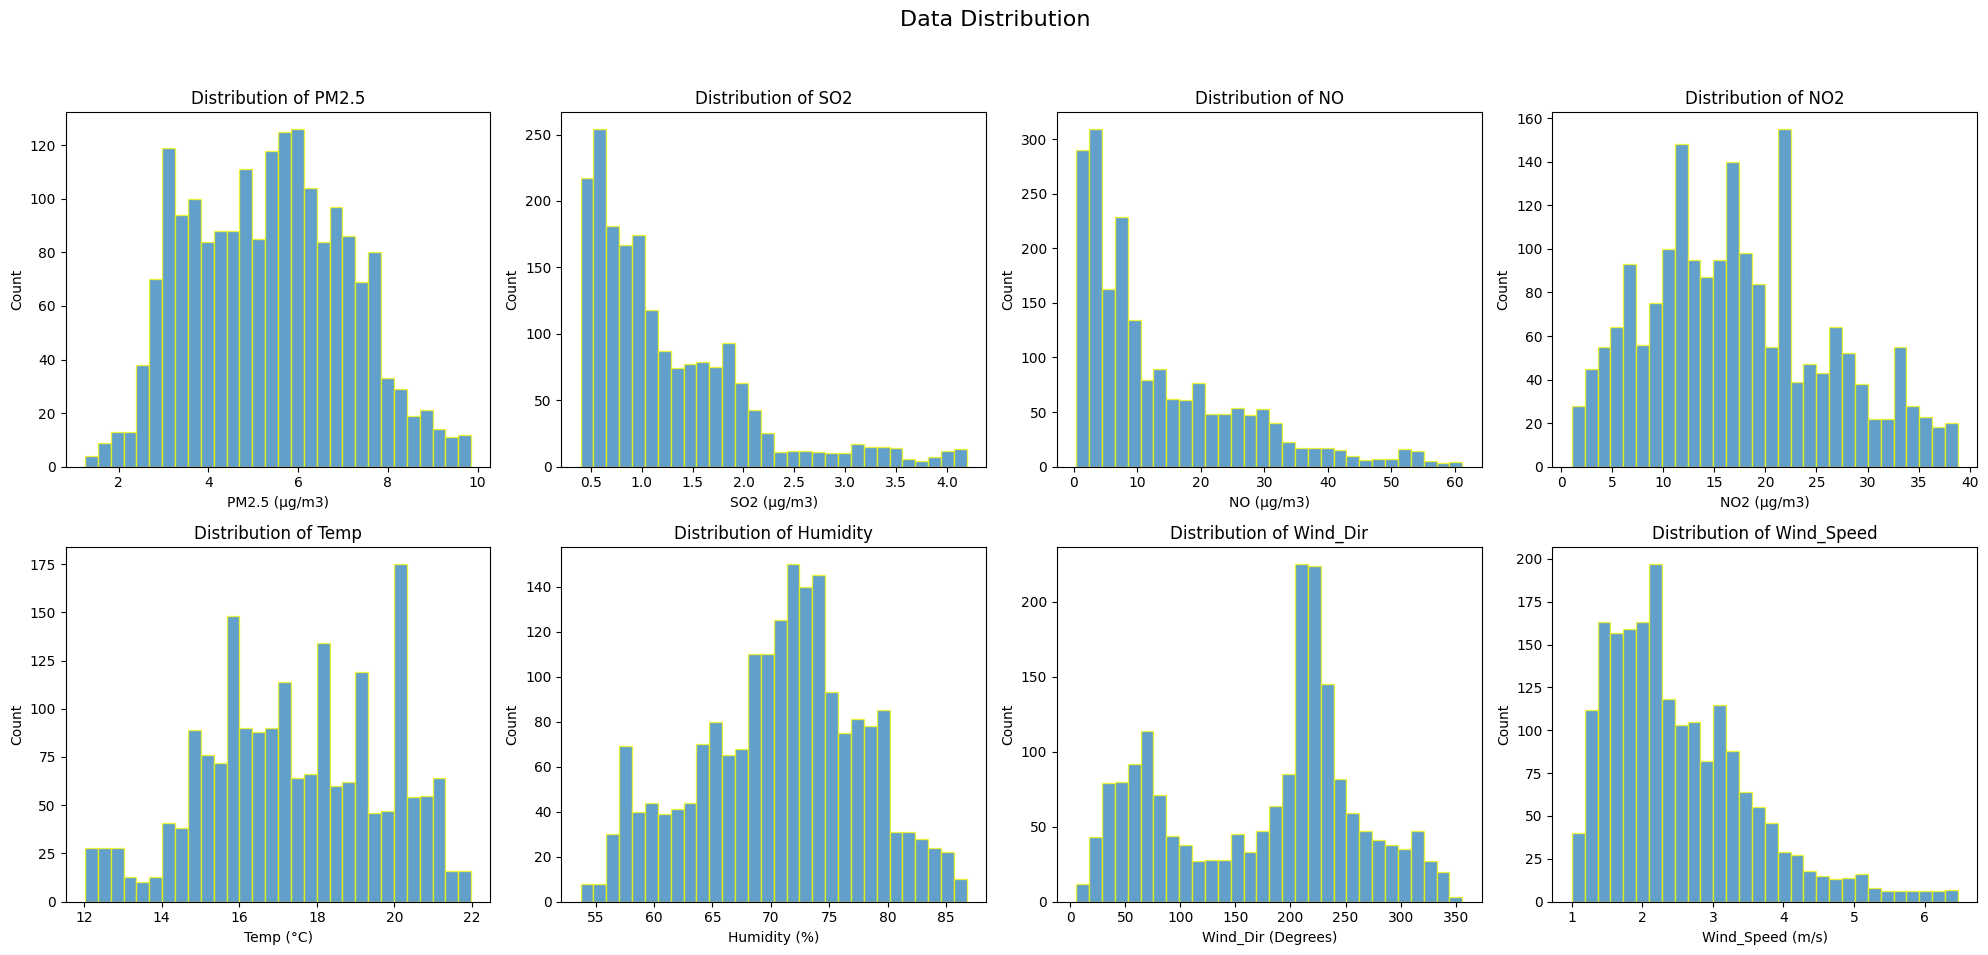

In [48]:
def show_time_series_hist_plot(df,columns_to_plot = ["PM2.5", "SO2", "NO", "NO2", "Temp", "Humidity", "Wind_Dir", "Wind_Speed"]):

    # Create the subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    fig.suptitle('Data Distribution', fontsize=16)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Define units for each column
    units = {
        "PM2.5": "μg/m3",
        "SO2": "μg/m3",
        "NO": "μg/m3",
        "NO2": "μg/m3",
        "Temp": "°C",
        "Humidity": "%",
        "Wind_Dir": "Degrees",
        "Wind_Speed": "m/s"
    }

    # Plot each column
    for i, column in enumerate(columns_to_plot):
        if i < len(axes):
            axes[i].hist(data[column].dropna(), bins=30, edgecolor='yellow', alpha=0.7)
            axes[i].set_title(f'Distribution of {column}')
            axes[i].set_xlabel(f'{column} ({units[column]})')
            axes[i].set_ylabel('Count')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

show_time_series_hist_plot(data)

### Data Type convert

In [49]:

# Assuming 'data' is already loaded into a DataFrame
df = pd.DataFrame(data)

# Converting 'start_time' and 'end_time' to datetime


df['start_time'] = pd.to_datetime(df['start_time'], format='%Y/%m/%d %H:%M')
df['end_time'] = pd.to_datetime(df['end_time'], format='%Y/%m/%d %H:%M')

# Converting other columns to float
columns_to_convert = ['Temp', 'Humidity', 'Wind_Speed', 'Wind_Dir', 'NO', 'NO2', 'SO2', 'PM2.5']

# Ensuring all values can be converted to float
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Convert columns to float
df[columns_to_convert] = df[columns_to_convert].astype(float)

# Check the data types and look for any conversion issues
print(df.info())

# Check for any NaN values introduced during conversion
print(df[columns_to_convert].isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_time  1944 non-null   datetime64[ns]
 1   end_time    1944 non-null   datetime64[ns]
 2   SO2         1896 non-null   float64       
 3   NO          1944 non-null   float64       
 4   NO2         1944 non-null   float64       
 5   Temp        1944 non-null   float64       
 6   Humidity    1944 non-null   float64       
 7   Wind_Dir    1923 non-null   float64       
 8   Wind_Speed  1944 non-null   float64       
 9   PM2.5       1944 non-null   float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 152.0 KB
None
Temp           0
Humidity       0
Wind_Speed     0
Wind_Dir      21
NO             0
NO2            0
SO2           48
PM2.5          0
dtype: int64


### Data Check

In [50]:
# data check
print("Number of observation: ", df.shape[0])# check dimension
print("Any NA value:", df.isnull().values.any()); #check for missing values
print("Any row duplictaes:",df.duplicated().any());#check for dupllicates rows


# Define the rules for identifying errors in each column
error_checks = {
    'Temp': "Temperature should be between -20°C and 40°C",
    'Humidity': "Humidity should be between 0% and 100%",
    'Wind_Speed': "Wind speed should be between 0 and 60 m/s",
    'Wind_Dir': "Wind direction should be between 0 and 360 degrees",
    'NO': "NO should be non-negative",
    'NO2': "NO2 should be non-negative",
    'SO2': "SO2 should be non-negative",
    'PM2.5': "PM2.5 should be non-negative"
}

# Functions to check each rule
error_functions = {
    'Temp': lambda x: (x < -20) | (x > 40),
    'Humidity': lambda x: (x < 0) | (x > 100),
    'Wind_Speed': lambda x: (x < 0) | (x > 60),
    'Wind_Dir': lambda x: (x < 0) | (x >= 360),
    'NO': lambda x: x < 0,
    'NO2': lambda x: x < 0,
    'SO2': lambda x: x < 0,
    'PM2.5': lambda x: x < 0
}

# Initialize lists to store results
columns = []
rules = []
error_counts = []
percentages = []

# Calculate the number of error values and percentages for each rule
for column, rule in error_checks.items():
    error_count = error_functions[column](df[column]).sum()
    error_percentage = (error_count / len(df)) * 100
    columns.append(column)
    rules.append(rule)
    error_counts.append(error_count)
    percentages.append(error_percentage)

# Combine the results into a DataFrame
error_data = pd.DataFrame({
    'Column Name': columns,
    'Rule': rules,
    'Error Count': error_counts,
    'Percentage': percentages
})

# Print the error data
print(error_data)

# Generate the report section
report_section = """
**Identifying Invalid Data**

In this section, we check for invalid data within the dataset. This step ensures data quality and reliability for further analysis and modeling. Below are the checks performed:

| Column Name | Rule | Error Count | Percentage |
|-------------|------|-------------|------------|
"""
for index, row in error_data.iterrows():
    report_section += f"| {row['Column Name']} | {row['Rule']} | {row['Error Count']} | {row['Percentage']:.2f}% |\n"

print(report_section)









Number of observation:  1944
Any NA value: True
Any row duplictaes: False
  Column Name                                               Rule  Error Count  \
0        Temp       Temperature should be between -20°C and 40°C            0   
1    Humidity             Humidity should be between 0% and 100%            0   
2  Wind_Speed          Wind speed should be between 0 and 60 m/s            0   
3    Wind_Dir  Wind direction should be between 0 and 360 deg...            0   
4          NO                          NO should be non-negative            0   
5         NO2                         NO2 should be non-negative            0   
6         SO2                         SO2 should be non-negative            0   
7       PM2.5                       PM2.5 should be non-negative            0   

   Percentage  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  

**Identifying Invalid Data**

In this section, we c

### **Missing Values.**

In [51]:
# Calculate the number of missing values for each column
missing_values_count = df.isnull().sum()

# Calculate the percentage of missing values for each column
missing_values_percentage = (df.isnull().sum() / len(df)) * 100

# Combine the results into a DataFrame
missing_data = pd.DataFrame({
    'Missing Values': missing_values_count,
    'Percentage': missing_values_percentage
})

# Sort the DataFrame by the number of missing values
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Print the report
print(missing_data)


            Missing Values  Percentage
SO2                     48    2.469136
Wind_Dir                21    1.080247
end_time                 0    0.000000
start_time               0    0.000000
NO2                      0    0.000000
NO                       0    0.000000
Temp                     0    0.000000
Humidity                 0    0.000000
Wind_Speed               0    0.000000
PM2.5                    0    0.000000


### **Invalid Data**

In [52]:
# Function to replace error values with NaN based on specified conditions
def replace_with_nan(df, column, condition):
    df[column] = df[column].apply(lambda x: x if condition(x) else None)

# Define the error conditions for each column
error_conditions = {
    'Temp': lambda x: -20 <= x <= 40,
    'Humidity': lambda x: 0 <= x <= 100,
    'Wind_Speed': lambda x: 0 <= x <= 60,
    'Wind_Dir': lambda x: 0 <= x < 360,
    'NO': lambda x: x >= 0,
    'NO2': lambda x: x >= 0,
    'SO2': lambda x: x >= 0,
    'PM2.5': lambda x: x >= 0,
}

# Replace error values with NaN for each column
for column, condition in error_conditions.items():
    replace_with_nan(df, column, condition)

# Fill NaN values with the previous non-NaN value for each column
# df.fillna(method='ffill', inplace=True)

# Display the number of error values for each column after replacement
print("Number of error values in 'Temp':", ((df['Temp'] < -20) | (df['Temp'] > 40)).sum())
print("Number of error values in 'Humidity':", ((df['Humidity'] < 0) | (df['Humidity'] > 100)).sum())
print("Number of error values in 'Wind_Speed':", ((df['Wind_Speed'] < 0) | (df['Wind_Speed'] > 60)).sum())
print("Number of error values in 'Wind_Dir':", ((df['Wind_Dir'] < 0) | (df['Wind_Dir'] >= 360)).sum())
print("Number of error values in 'NO':", (df['NO'] < 0).sum())
print("Number of error values in 'NO2':", (df['NO2'] < 0).sum())
print("Number of error values in 'SO2':", (df['SO2'] < 0).sum())
print("Number of error values in 'PM2.5':", (df['PM2.5'] < 0).sum())


df.isnull().sum()

Number of error values in 'Temp': 0
Number of error values in 'Humidity': 0
Number of error values in 'Wind_Speed': 0
Number of error values in 'Wind_Dir': 0
Number of error values in 'NO': 0
Number of error values in 'NO2': 0
Number of error values in 'SO2': 0
Number of error values in 'PM2.5': 0


start_time     0
end_time       0
SO2           48
NO             0
NO2            0
Temp           0
Humidity       0
Wind_Dir      21
Wind_Speed     0
PM2.5          0
dtype: int64

### **Outliers**

  Column Name  Outlier Count  Percentage
0         SO2             90    4.629630
1          NO             72    3.703704
2         NO2              0    0.000000
3        Temp              0    0.000000
4    Humidity              0    0.000000
5    Wind_Dir              0    0.000000
6  Wind_Speed             51    2.623457
7       PM2.5              0    0.000000


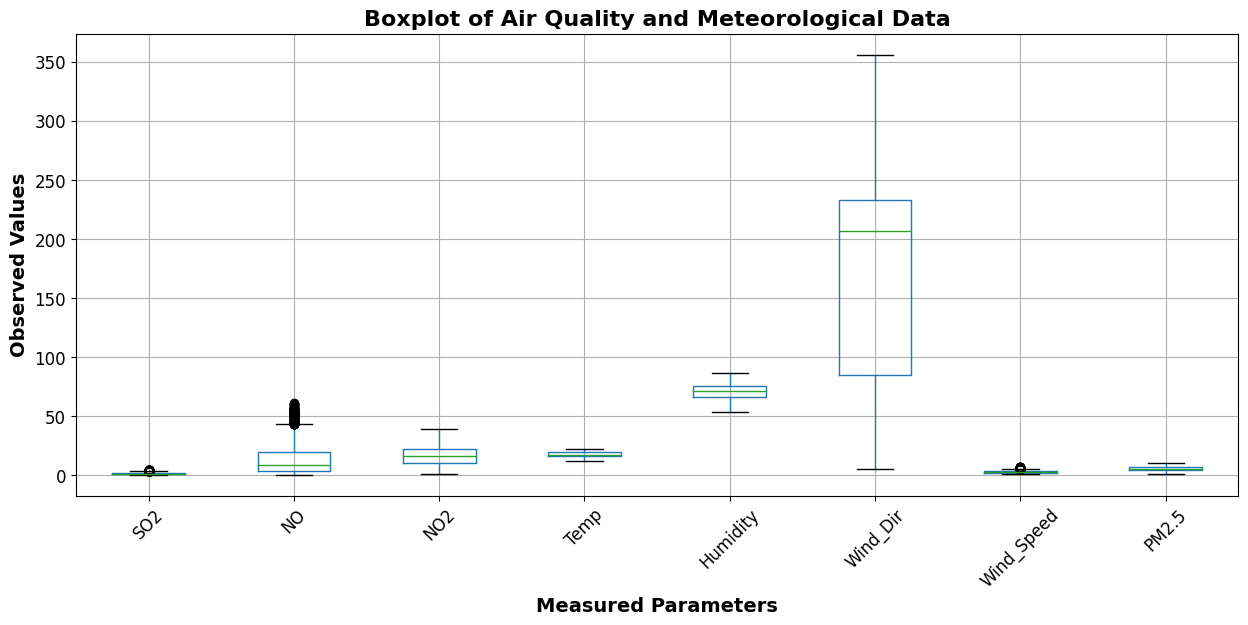

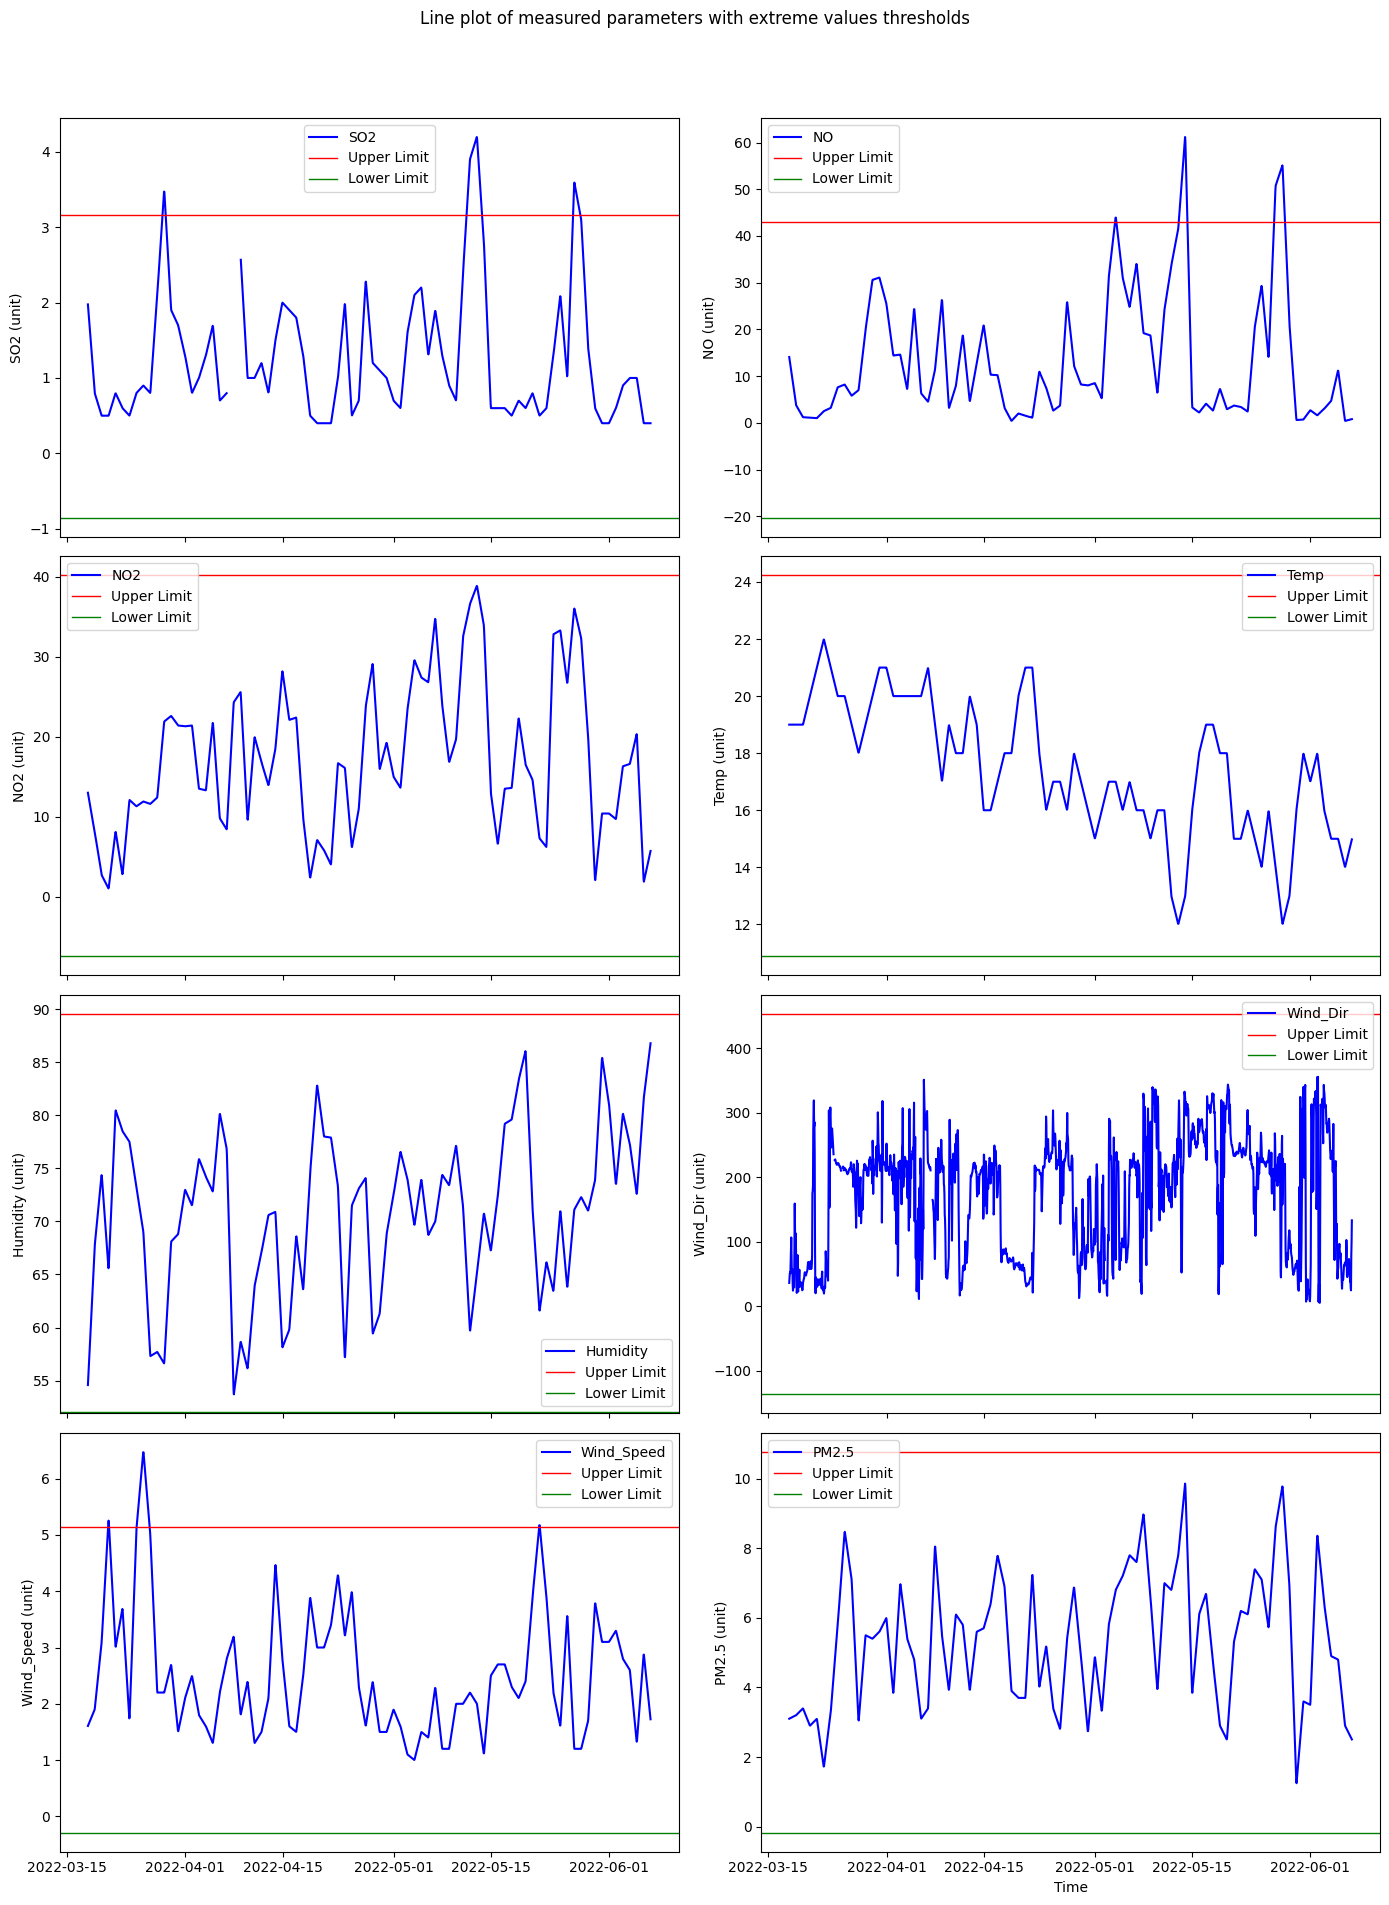


    **Identifying Outliers**

    In this section, we identify outliers within the dataset. Outliers are data points that fall significantly outside the range of most of the data. Identifying and handling outliers is crucial for ensuring the accuracy of the analysis and modeling. Below are the outlier statistics for each column:

    | Column Name | Outlier Count | Percentage |
    |-------------|---------------|------------|
    | SO2 | 90 | 4.63% |
| NO | 72 | 3.70% |
| NO2 | 0 | 0.00% |
| Temp | 0 | 0.00% |
| Humidity | 0 | 0.00% |
| Wind_Dir | 0 | 0.00% |
| Wind_Speed | 51 | 2.62% |
| PM2.5 | 0 | 0.00% |



In [53]:

def analyze_outliers(df):
    # Copy df to df_pm25
    df_pm25 = df.copy()

    # Function to calculate and plot for each column
    def plot_parameters(df, parameters, lower_bound, upper_bound):
        num_parameters = len(parameters)
        cols = 2
        rows = (num_parameters + 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), sharex=True)

        axes = axes.flatten()  # Flatten the 2D array of axes to 1D

        for i, parameter in enumerate(parameters):
            # Flag and remove extreme values
            df['is_extreme'] = ((df[parameter] > upper_bound[parameter]) | (df[parameter] < lower_bound[parameter]))
            df_cleaned = df[~df['is_extreme']]

            # Plot parameter trend over time with upper and lower limits
            axes[i].plot(df["start_time"], df[parameter], label=parameter, color='blue')
            axes[i].axhline(y=upper_bound[parameter], color='red', linewidth=1, label='Upper Limit')
            axes[i].axhline(y=lower_bound[parameter], color='green', linewidth=1, label='Lower Limit')
            axes[i].set_ylabel(f"{parameter} (unit)")  # Change the unit according to the parameter
            axes[i].legend()

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.xlabel("Time")
        plt.suptitle("Line plot of measured parameters with extreme values thresholds")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

     # Remove the time columns for analysis if they exist
    time_columns = ['start_time', 'end_time']
    df_without_time = df.drop(columns=[col for col in time_columns if col in df.columns])


    # Describe the DataFrame to get the statistical summary
    stats = df_without_time.describe().T

    # Calculate the IQR (Interquartile Range) for each column
    IQR = stats['75%'] - stats['25%']

    # Define the lower and upper bounds for outliers
    lower_bound = stats['25%'] - 1.5 * IQR
    upper_bound = stats['75%'] + 1.5 * IQR

    # Initialize lists to store results
    columns = []
    outlier_counts = []
    percentages = []

    # Calculate the number of outliers and percentages for each column
    for column in df_without_time.columns:
        outlier_count = ((df_without_time[column] < lower_bound[column]) | (df_without_time[column] > upper_bound[column])).sum()
        outlier_percentage = (outlier_count / len(df)) * 100
        columns.append(column)
        outlier_counts.append(outlier_count)
        percentages.append(outlier_percentage)

    # Combine the results into a DataFrame
    outlier_data = pd.DataFrame({
        'Column Name': columns,
        'Outlier Count': outlier_counts,
        'Percentage': percentages
    })

    # Print the outlier data
    print(outlier_data)

    # Generate the boxplot for all parameters
    fig, ax = plt.subplots(figsize=(15, 6))
    df_without_time.boxplot(ax=ax)

    # Set the title and labels of the plot
    plt.title("Boxplot of Air Quality and Meteorological Data", fontsize=16, fontweight='bold')
    plt.xlabel("Measured Parameters", fontsize=14, fontweight='bold')
    plt.ylabel("Observed Values", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Display the plot
    plt.show()

    # Generate combined plot for all parameters
    plot_parameters(df_pm25, df_without_time.columns, lower_bound, upper_bound)

    # Generate the report section
    report_section = """
    **Identifying Outliers**

    In this section, we identify outliers within the dataset. Outliers are data points that fall significantly outside the range of most of the data. Identifying and handling outliers is crucial for ensuring the accuracy of the analysis and modeling. Below are the outlier statistics for each column:

    | Column Name | Outlier Count | Percentage |
    |-------------|---------------|------------|
    """
    for index, row in outlier_data.iterrows():
        report_section += f"| {row['Column Name']} | {row['Outlier Count']} | {row['Percentage']:.2f}% |\n"

    print(report_section)

# show
analyze_outliers(df)

In [54]:

df_without_time = df.drop(columns=['start_time','end_time'])
df_without_time.describe().T



count        mean        std        min        25%         50%  \
SO2         1896.0    1.253165   0.796637   0.400000   0.654167    1.000000   
NO          1944.0   13.253704  12.613353   0.408333   3.443750    8.343750   
NO2         1944.0   17.168519   8.761585   1.035417  10.434896   16.379167   
Temp        1944.0   17.432099   2.270050  12.020833  15.895833   17.375000   
Humidity    1944.0   70.798765   6.985182  53.706250  66.101562   71.525000   
Wind_Dir    1923.0  175.697088  86.197476   5.500000  85.000000  206.500000   
Wind_Speed  1944.0    2.515432   1.024951   1.002083   1.743750    2.256250   
PM2.5       1944.0    5.361728   1.731481   1.250000   3.926562    5.431250   

                   75%         max  
SO2           1.656771    4.193750  
NO           19.256250   61.183333  
NO2          22.326563   38.852083  
Temp         19.229167   21.979167  
Humidity     75.486458   86.789583  
Wind_Dir    232.500000  356.000000  
Wind_Speed    3.100000    6.470833  
PM2.5         6.659375    9.856250

## **1.2 Data Cleaning.**


In [55]:
# Define invalid data conditions
invalid_conditions = {
    'Temp': lambda x: (x < -20) | (x > 40),
    'Humidity': lambda x: (x < 0) | (x > 100),
    'Wind_Speed': lambda x: (x < 0) | (x > 60),
    'Wind_Dir': lambda x: (x < 0) | (x >= 360),
    'NO': lambda x: x < 0,
    'NO2': lambda x: x < 0,
    'SO2': lambda x: x < 0,
    'PM2.5': lambda x: x < 0
}

# Replace invalid data with NaN
for col, condition in invalid_conditions.items():
    df.loc[condition(df[col]), col] = np.nan

# Remove the time columns for analysis
df_without_time = df.drop(columns=['start_time', 'end_time'])

# Describe the DataFrame to get the statistical summary
stats = df_without_time.describe().T

# Calculate the IQR (Interquartile Range) for each column
IQR = stats['75%'] - stats['25%']

# Define the lower and upper bounds for outliers
lower_bound = stats['25%'] - 1.5 * IQR
upper_bound = stats['75%'] + 1.5 * IQR

# Replace outliers with NaN
for column in df_without_time.columns:
    df.loc[(df_without_time[column] < lower_bound[column]) | (df_without_time[column] > upper_bound[column]), column] = np.nan

# Verify the updated dataset
print(df.info())

# Generate the report section
report_section = """
**Replacing Invalid Data and Outliers with Null Values**

In this section, we replace invalid data and outliers with null values (`NaN`). This preprocessing step is crucial to ensure the quality of the dataset before further analysis and modeling.

**Invalid Data Replacement Logic:**
- Temperature (`Temp`): Values less than -20°C or greater than 40°C are considered invalid.
- Humidity (`Humidity`): Values less than 0% or greater than 100% are considered invalid.
- Wind Speed (`Wind_Speed`): Values less than 0 or greater than 60 m/s are considered invalid.
- Wind Direction (`Wind_Dir`): Values less than 0 or greater than or equal to 360 degrees are considered invalid.
- Nitric Oxide (`NO`), Nitrogen Dioxide (`NO2`), Sulfur Dioxide (`SO2`), and Particulate Matter (`PM2.5`): Negative values are considered invalid.

**Outlier Replacement Logic:**
Outliers are identified using the Interquartile Range (IQR) method. Data points falling below the lower bound or above the upper bound are considered outliers and replaced with `NaN`.
- Lower Bound = 25th percentile - 1.5 * IQR
- Upper Bound = 75th percentile + 1.5 * IQR

Below is the verification of the updated dataset:

"""
report_section += str(df.info())

print(report_section)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_time  1944 non-null   datetime64[ns]
 1   end_time    1944 non-null   datetime64[ns]
 2   SO2         1806 non-null   float64       
 3   NO          1872 non-null   float64       
 4   NO2         1944 non-null   float64       
 5   Temp        1944 non-null   float64       
 6   Humidity    1944 non-null   float64       
 7   Wind_Dir    1923 non-null   float64       
 8   Wind_Speed  1893 non-null   float64       
 9   PM2.5       1944 non-null   float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 152.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_time  1944 non-null   datetime64[ns]


### Result after replacing invalid data with NaN

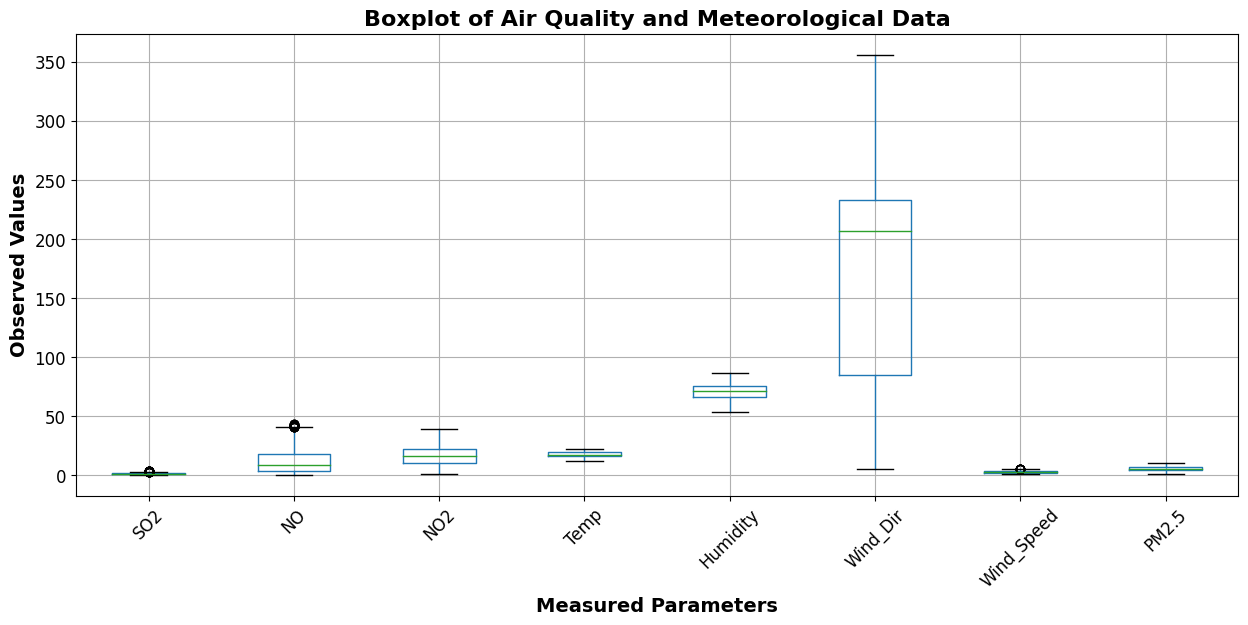

In [56]:

# Create a figure and a set of subplots with a specified size
fig, ax = plt.subplots(figsize=(15, 6))

# Generate a boxplot of the DataFrame df on the specified axes ax
df.boxplot(ax=ax)

# Set the title of the plot with a more descriptive title
plt.title("Boxplot of Air Quality and Meteorological Data", fontsize=16, fontweight='bold')

# Set the x-axis label with a more descriptive label
plt.xlabel("Measured Parameters", fontsize=14, fontweight='bold')

# Set the y-axis label with a more descriptive label
plt.ylabel("Observed Values", fontsize=14, fontweight='bold')

# Optionally, rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Set the y-axis label font size
plt.yticks(fontsize=12)

# Display the plot
plt.show()

### Generate a complete hourly frequency data source

In [57]:

# Title: Checking for Continuous Time Series and Inserting Missing Time Points
# Description: This script checks if the 'start_time' values in a dataframe are continuous.
# If not, it inserts the missing time points with hourly frequency.


# Generate a complete time range with hourly frequency
full_time_range = pd.date_range(start=df['start_time'].min(), end=df['start_time'].max(), freq='H')

# Set the dataframe index to start_time
df.set_index('start_time', inplace=True)

# Reindex the dataframe to include the complete time range
df = df.reindex(full_time_range)

# Reset the index and rename the column back to start_time
df.reset_index(inplace=True)
df.rename(columns={'index': 'start_time'}, inplace=True)

# Print the first few rows to check the result
print(df.head())

           start_time            end_time    SO2        NO        NO2  Temp  \
0 2022-03-18 00:00:00 2022-03-18 01:00:00  1.975  14.08125  12.995833  19.0   
1 2022-03-18 01:00:00 2022-03-18 02:00:00  1.925  13.64375  12.787500  19.0   
2 2022-03-18 02:00:00 2022-03-18 03:00:00  1.875  13.20625  12.579167  19.0   
3 2022-03-18 03:00:00 2022-03-18 04:00:00  1.825  12.76875  12.370833  19.0   
4 2022-03-18 04:00:00 2022-03-18 05:00:00  1.775  12.33125  12.162500  19.0   

    Humidity  Wind_Dir  Wind_Speed     PM2.5  
0  54.579167      36.5     1.60625  3.102083  
1  55.137500      44.5     1.61875  3.106250  
2  55.695833      51.0     1.63125  3.110417  
3  56.254167      53.0     1.64375  3.114583  
4  56.812500      51.5     1.65625  3.118750  


In [58]:

df_without_time = df.drop(columns=['start_time','end_time'])
df_without_time.describe().T


count        mean        std        min        25%         50%  \
SO2         1806.0    1.134659   0.603999   0.400000   0.640625    0.989583   
NO          1872.0   11.793610  10.334825   0.408333   3.349479    8.125000   
NO2         1944.0   17.168519   8.761585   1.035417  10.434896   16.379167   
Temp        1944.0   17.432099   2.270050  12.020833  15.895833   17.375000   
Humidity    1944.0   70.798765   6.985182  53.706250  66.101562   71.525000   
Wind_Dir    1923.0  175.697088  86.197476   5.500000  85.000000  206.500000   
Wind_Speed  1893.0    2.428359   0.885968   1.002083   1.731250    2.229167   
PM2.5       1944.0    5.361728   1.731481   1.250000   3.926562    5.431250   

                   75%         max  
SO2           1.548437    3.152083  
NO           18.190625   42.850000  
NO2          22.326563   38.852083  
Temp         19.229167   21.979167  
Humidity     75.486458   86.789583  
Wind_Dir    232.500000  356.000000  
Wind_Speed    3.054167    5.129167  
PM2.5         6.659375    9.856250

### Data Imputation Method Comparison

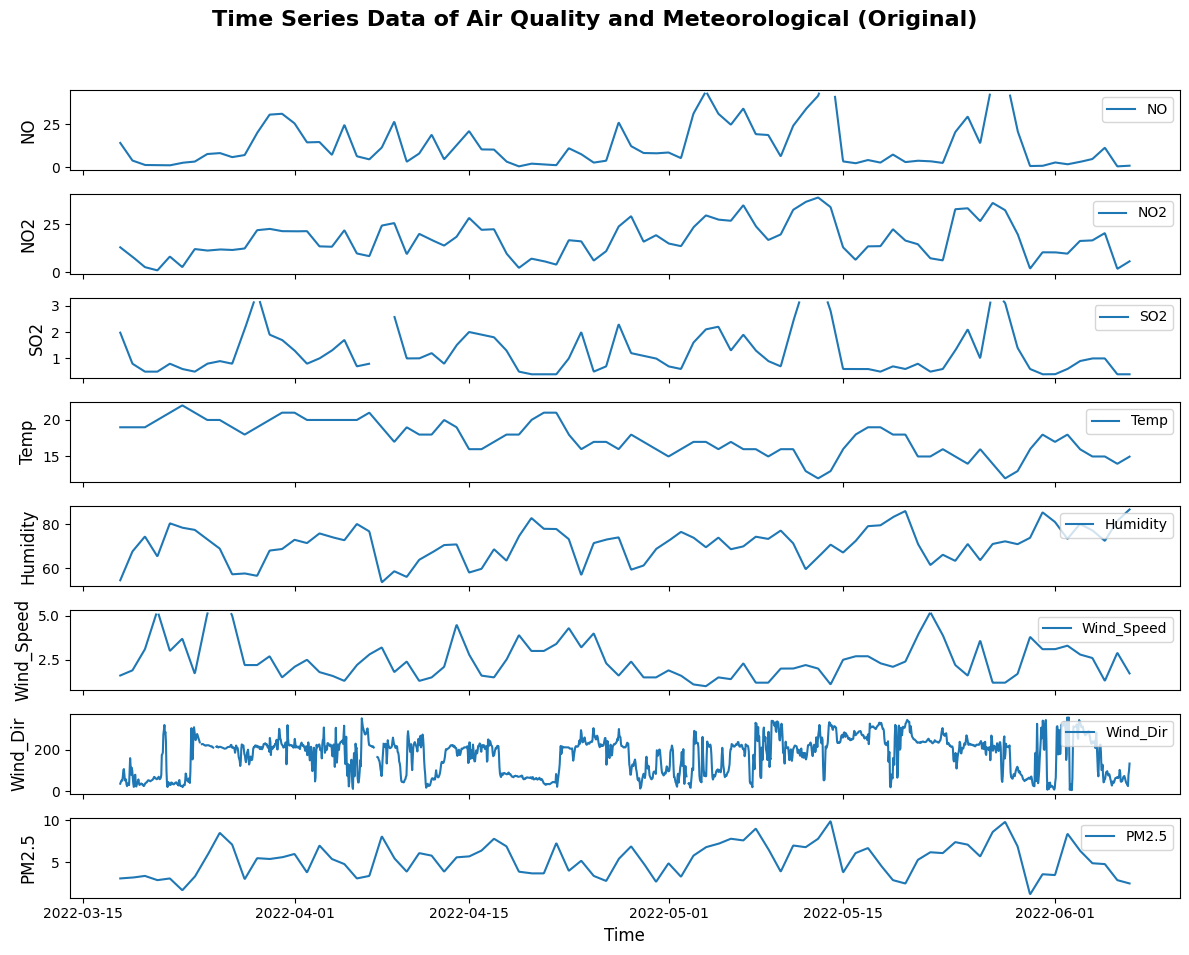

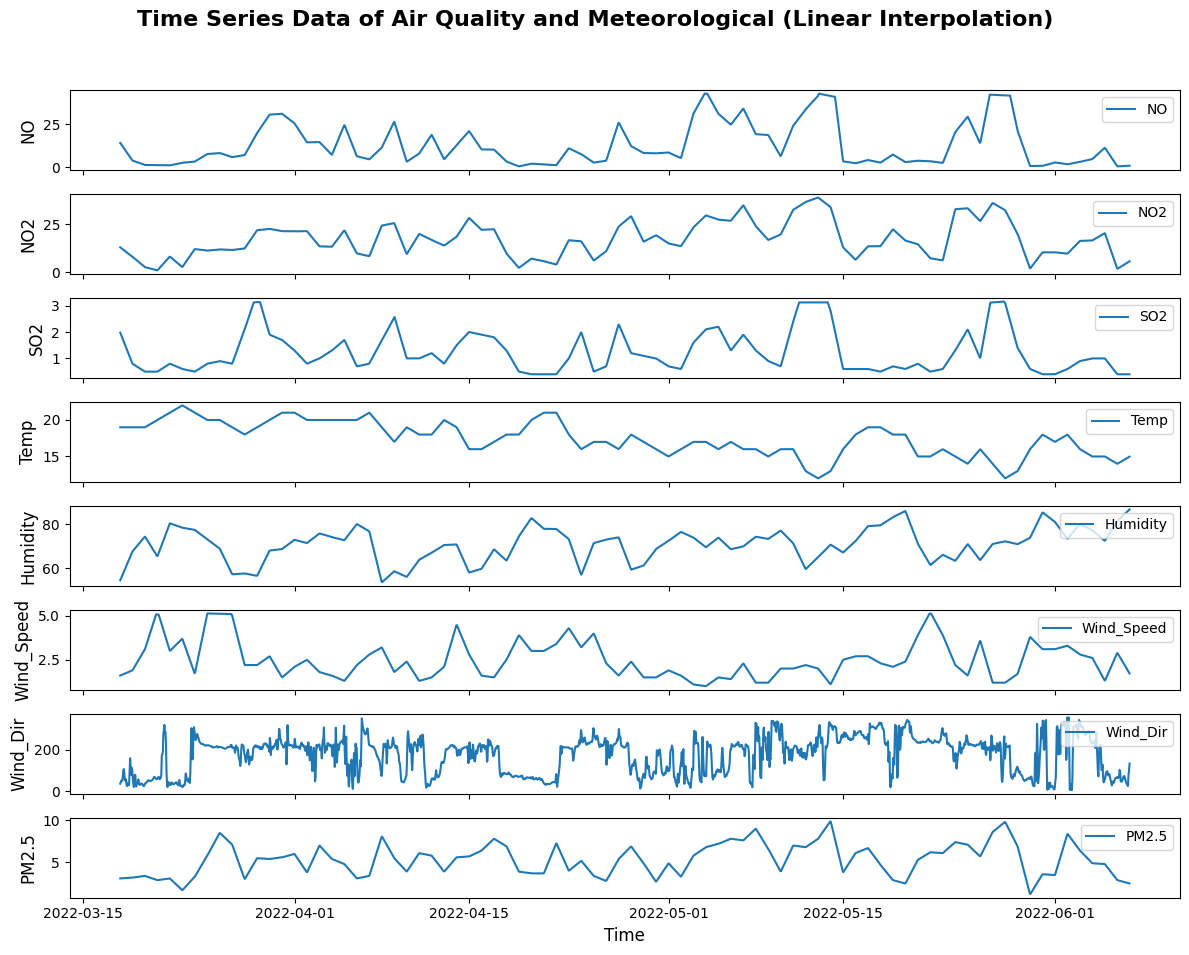

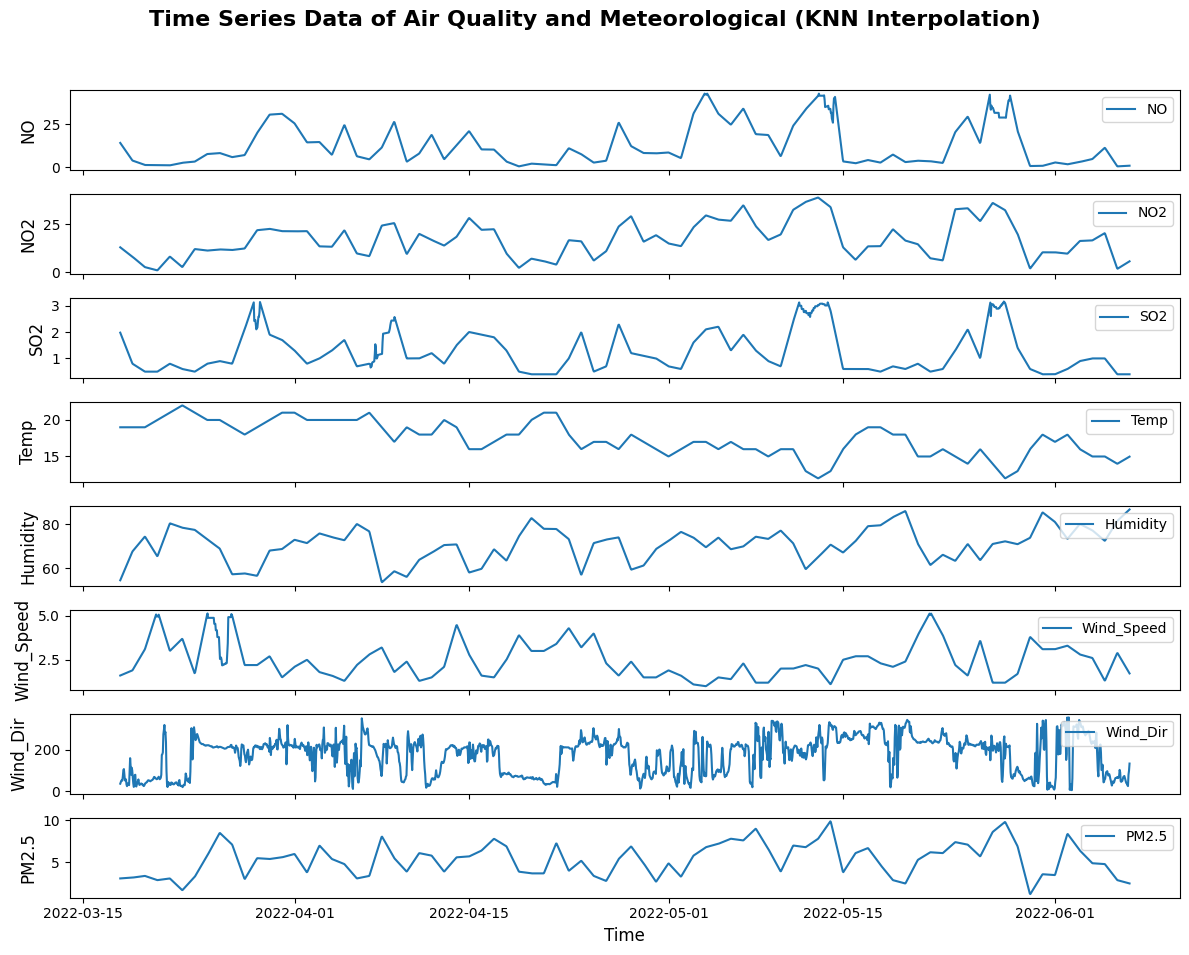

       Column  MSE_Linear  MAE_Linear   MSE_KNN   MAE_KNN
0        Temp    0.000000    0.000000  0.000000  0.000000
1    Humidity    0.000000    0.000000  0.000000  0.000000
2  Wind_Speed    0.000010    0.000421  0.066410  0.029931
3          NO    0.020118    0.019949  2.632647  0.263510
4         NO2    0.000000    0.000000  0.000000  0.000000
5         SO2    0.025493    0.022155  0.040298  0.038039
6       PM2.5    0.000000    0.000000  0.000000  0.000000
7    Wind_Dir    1.175806    0.079347  1.175806  0.079347


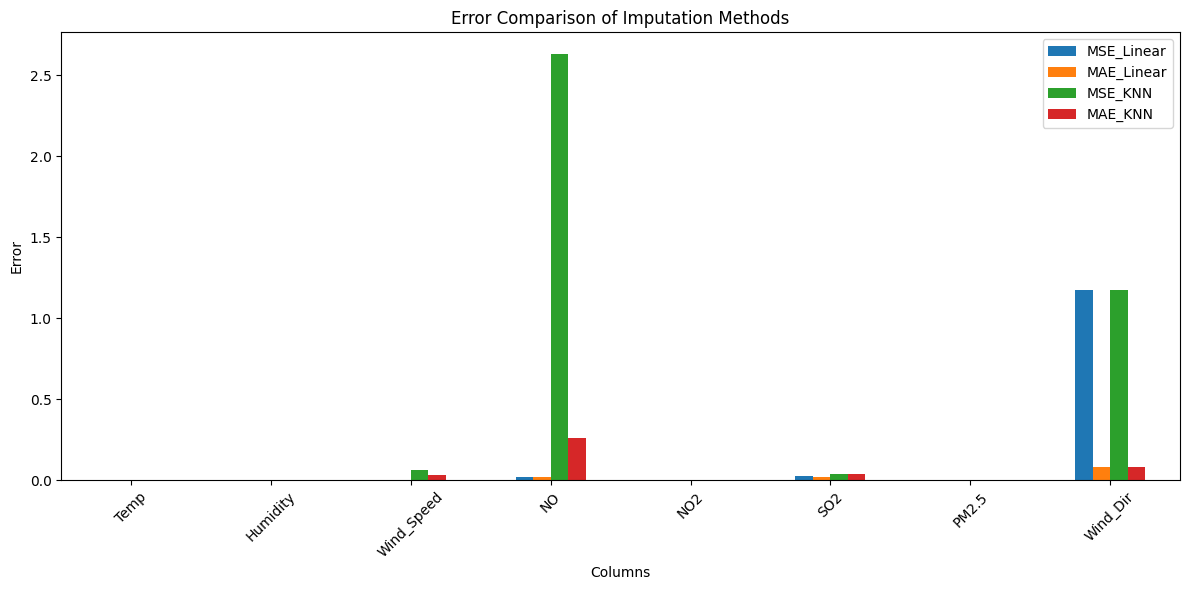

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to show time series plot
def show_time_series_plot(df, title):
    columns_to_plot = ['NO', 'NO2', 'SO2', 'Temp', 'Humidity', 'Wind_Speed', 'Wind_Dir', 'PM2.5']
    fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 10), sharex=True)

    for i, col in enumerate(columns_to_plot):
        axes[i].plot(df['start_time'], df[col], label=col)
        axes[i].set_ylabel(col, fontsize=12)
        axes[i].legend(loc='upper right')

    axes[-1].set_xlabel('Time', fontsize=12)
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Handle Wind_Dir using circular statistics
def impute_wind_direction(df):
    # Convert wind direction to sine and cosine components
    df['Wind_Dir_sin'] = np.sin(np.deg2rad(df['Wind_Dir']))
    df['Wind_Dir_cos'] = np.cos(np.deg2rad(df['Wind_Dir']))

    # Interpolate the sine and cosine components
    df['Wind_Dir_sin'] = df['Wind_Dir_sin'].interpolate(method='linear', limit_direction='both')
    df['Wind_Dir_cos'] = df['Wind_Dir_cos'].interpolate(method='linear', limit_direction='both')

    # Convert back to wind direction
    df['Wind_Dir'] = np.rad2deg(np.arctan2(df['Wind_Dir_sin'], df['Wind_Dir_cos']))
    df['Wind_Dir'] = df['Wind_Dir'] % 360  # Ensure the values are within [0, 360]
    df.drop(columns=['Wind_Dir_sin', 'Wind_Dir_cos'], inplace=True)
    return df

# Show initial time series plot
show_time_series_plot(df, 'Time Series Data of Air Quality and Meteorological (Original)')

# Linear interpolation to repair the missing values
columns_to_impute = ['Temp', 'Humidity', 'Wind_Speed', 'NO', 'NO2', 'SO2', 'PM2.5']

df_interpolated = df.copy()
df_interpolated[columns_to_impute] = df_interpolated[columns_to_impute].interpolate(method='linear', limit_direction='both')
df_interpolated = impute_wind_direction(df_interpolated)

# Show time series plot after linear interpolation
show_time_series_plot(df_interpolated, 'Time Series Data of Air Quality and Meteorological (Linear Interpolation)')

# KNN to repair the missing values
imputer = KNNImputer(n_neighbors=5)
df_knn = df.copy()
df_knn[columns_to_impute] = imputer.fit_transform(df_knn[columns_to_impute])
df_knn = impute_wind_direction(df_knn)

# Show time series plot after KNN interpolation
show_time_series_plot(df_knn, 'Time Series Data of Air Quality and Meteorological (KNN Interpolation)')

# Calculate errors
def calculate_errors(original, imputed):
    mse = mean_squared_error(original, imputed)
    mae = mean_absolute_error(original, imputed)
    return mse, mae

df_original = df.fillna(method='bfill').fillna(method='ffill')  # Use backfill and forward fill for demonstration
errors = []

for col in columns_to_impute + ['Wind_Dir']:
    mse_linear, mae_linear = calculate_errors(df_original[col], df_interpolated[col])
    mse_knn, mae_knn = calculate_errors(df_original[col], df_knn[col])
    errors.append([col, mse_linear, mae_linear, mse_knn, mae_knn])

# Create a DataFrame for error comparison
errors_df = pd.DataFrame(errors, columns=['Column', 'MSE_Linear', 'MAE_Linear', 'MSE_KNN', 'MAE_KNN'])

# Print the errors DataFrame
print(errors_df)

# Visualize the comparison
errors_df.set_index('Column').plot(kind='bar', figsize=(12, 6))
plt.title('Error Comparison of Imputation Methods')
plt.ylabel('Error')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### After Data Imputation

  Column Name  Outlier Count  Percentage
0         SO2              0         0.0
1          NO              0         0.0
2         NO2              0         0.0
3        Temp              0         0.0
4    Humidity              0         0.0
5    Wind_Dir              0         0.0
6  Wind_Speed              0         0.0
7       PM2.5              0         0.0


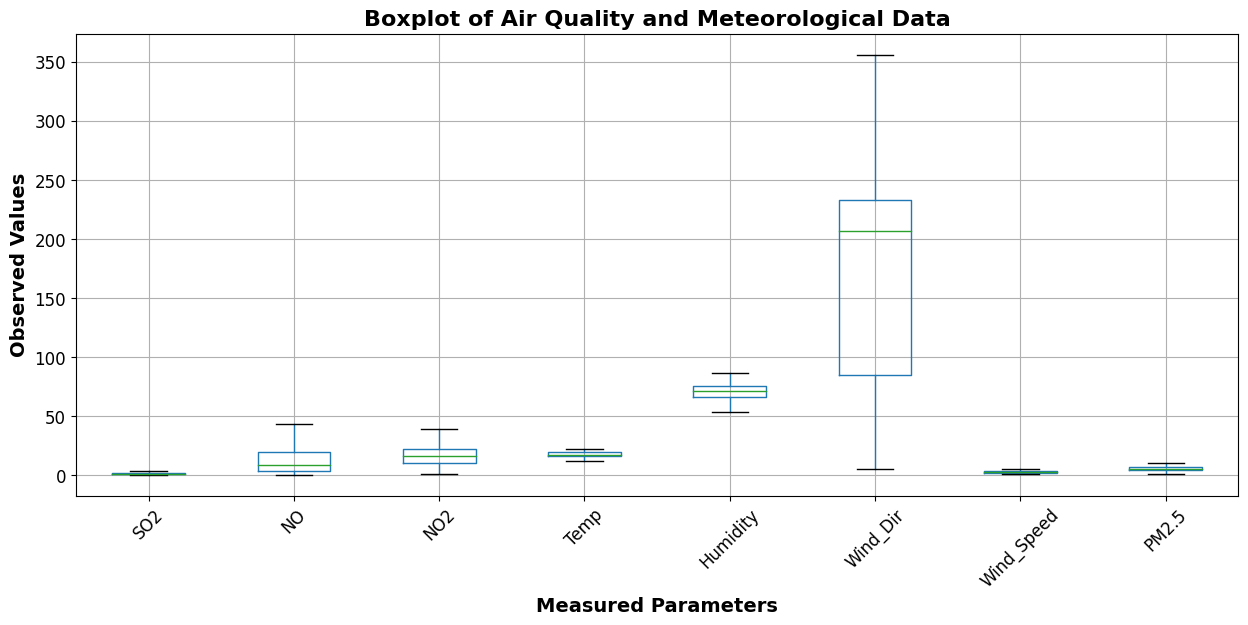

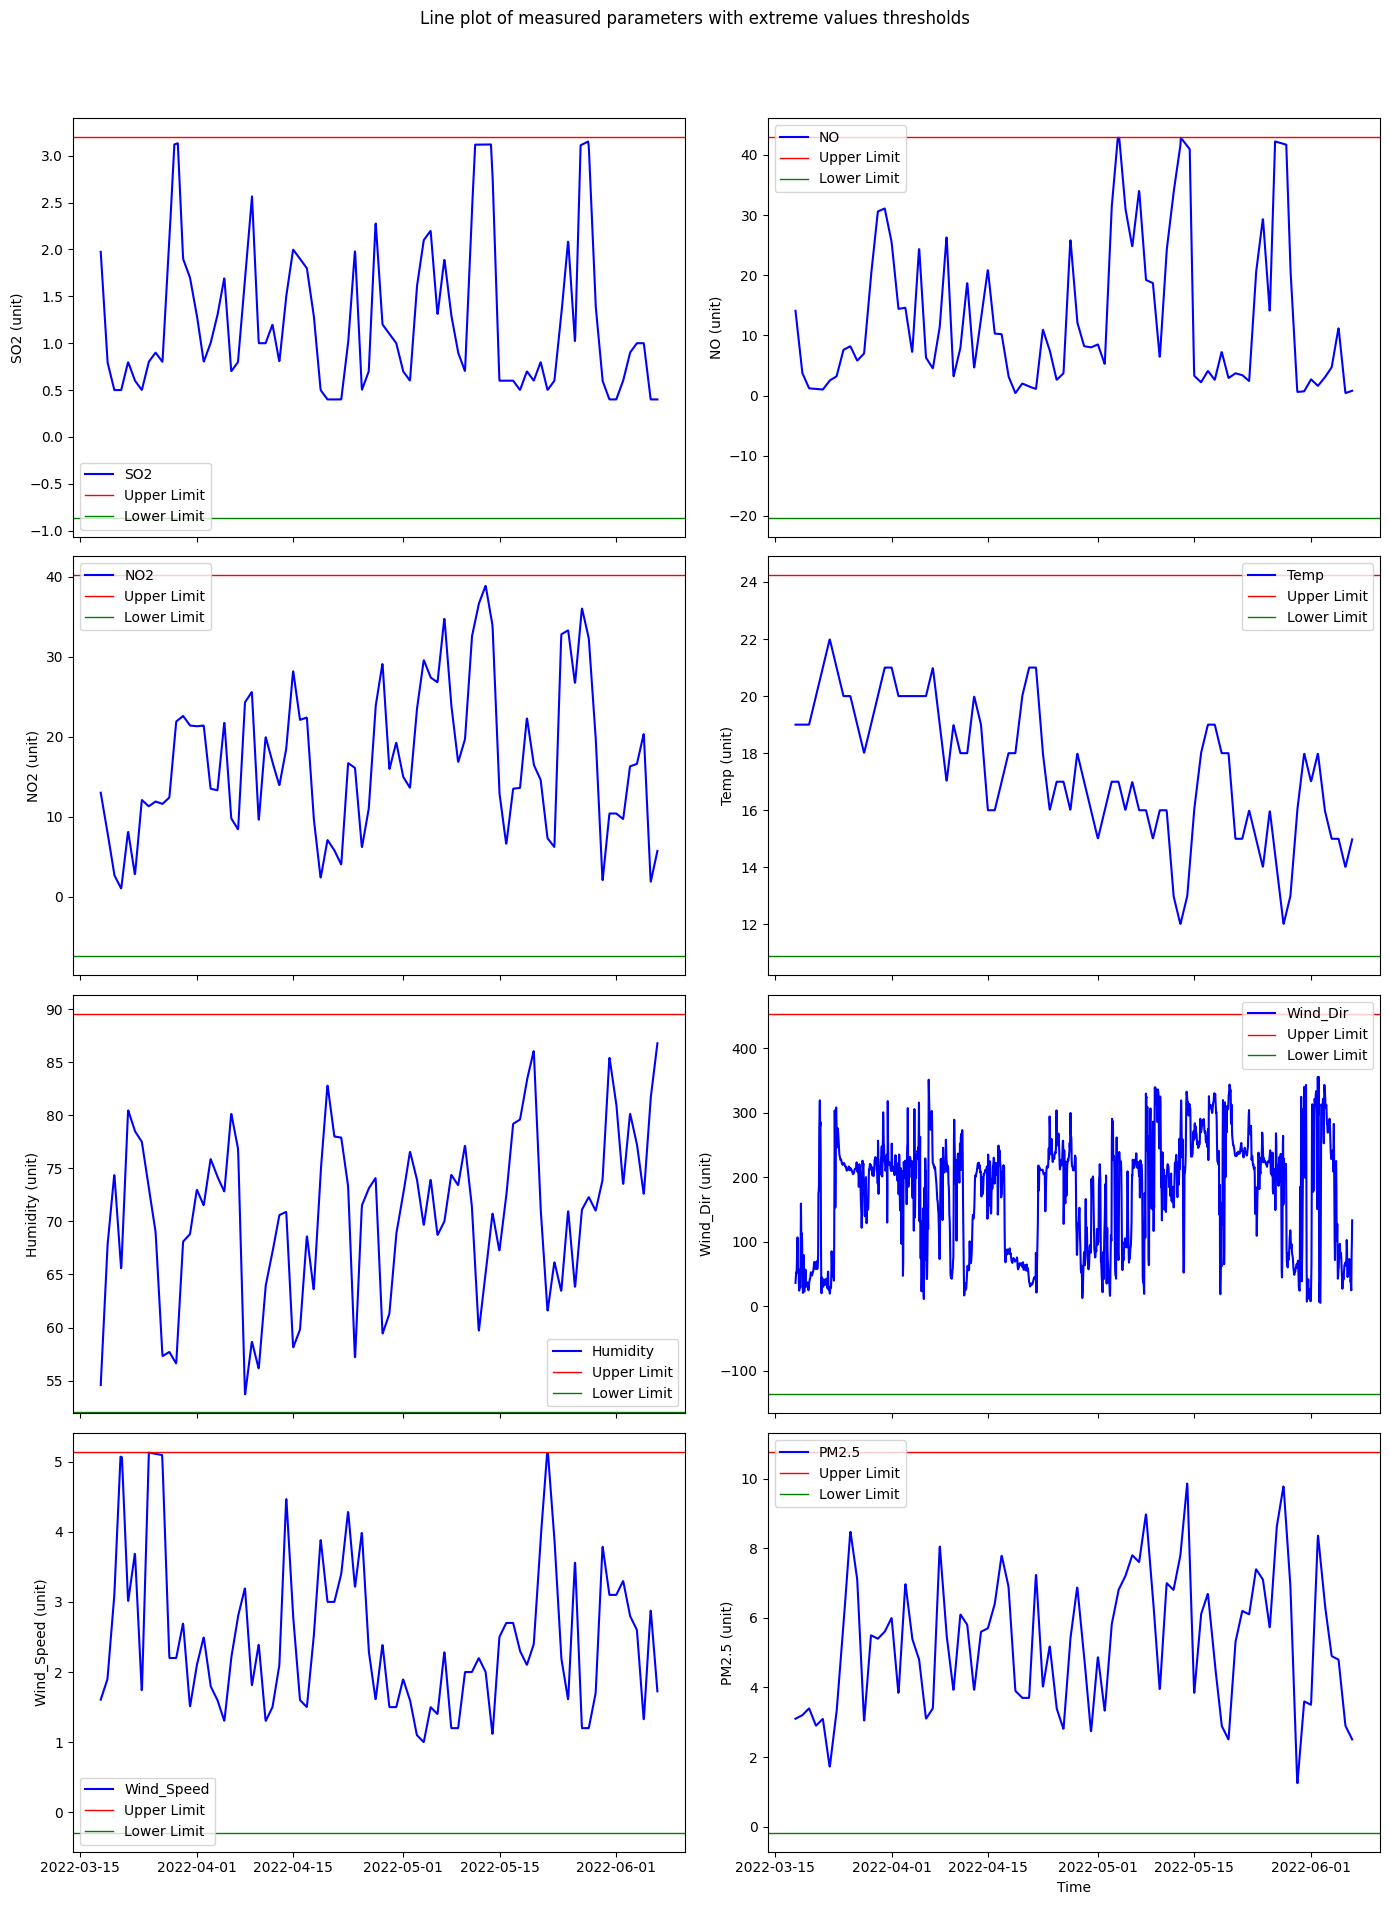


    **Identifying Outliers**

    In this section, we identify outliers within the dataset. Outliers are data points that fall significantly outside the range of most of the data. Identifying and handling outliers is crucial for ensuring the accuracy of the analysis and modeling. Below are the outlier statistics for each column:

    | Column Name | Outlier Count | Percentage |
    |-------------|---------------|------------|
    | SO2 | 0 | 0.00% |
| NO | 0 | 0.00% |
| NO2 | 0 | 0.00% |
| Temp | 0 | 0.00% |
| Humidity | 0 | 0.00% |
| Wind_Dir | 0 | 0.00% |
| Wind_Speed | 0 | 0.00% |
| PM2.5 | 0 | 0.00% |



In [60]:
# we choose line interpolated result
df = df_interpolated

analyze_outliers(df)

## **1.3 Extract New Features.**


In [61]:
# Creating lag1 (1 hours before) and lag2 (2 hours before) for PM2.5
df['lag1'] = df['PM2.5'].shift(1)
df['lag2'] = df['PM2.5'].shift(2)
df['lag1_time'] = df['start_time'].shift(1)
df['lag2_time'] = df['start_time'].shift(2)

# Setting the target to be the PM2.5 value next 1 hours into the future
#df['PM2.5'] = df['PM2.5'].shift(-1)
#df['target_time'] = df['start_time'].shift(-1)

# Ensuring the time shifts are accurate
df['lag1'] = np.where((df['start_time'] - pd.Timedelta(hours=1)) != df['lag1_time'], np.nan, df['lag1'])
df['lag2'] = np.where((df['start_time'] - pd.Timedelta(hours=2)) != df['lag2_time'], np.nan, df['lag2'])
#df['PM2.5'] = np.where((df['start_time'] + pd.Timedelta(hours=1)) != df['target_time'], np.nan, df['PM2.5'])

# Dropping the temporary time columns used for validation
df = df.drop(columns=['lag1_time', 'lag2_time']) #, 'target_time'

# Create Month and Day_Of_Week columns
df['Month'] = df['start_time'].dt.month
df['Day_Of_Week'] = df['start_time'].dt.dayofweek

# Drop rows where PM2.5, lag1, or lag2 are NaN
df = df.dropna(subset=['lag1', 'lag2']) #'PM2.5',

# Verify the updated DataFrame
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 2 to 1943
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   start_time   1942 non-null   datetime64[ns]
 1   end_time     1942 non-null   datetime64[ns]
 2   SO2          1942 non-null   float64       
 3   NO           1942 non-null   float64       
 4   NO2          1942 non-null   float64       
 5   Temp         1942 non-null   float64       
 6   Humidity     1942 non-null   float64       
 7   Wind_Dir     1942 non-null   float64       
 8   Wind_Speed   1942 non-null   float64       
 9   PM2.5        1942 non-null   float64       
 10  lag1         1942 non-null   float64       
 11  lag2         1942 non-null   float64       
 12  Month        1942 non-null   int32         
 13  Day_Of_Week  1942 non-null   int32         
dtypes: datetime64[ns](2), float64(10), int32(2)
memory usage: 212.4 KB
None
           start_time            end_

## **1.4 Converting Categorical Data Types.**


In [62]:
# Define a function to categorize wind direction
def categorize_wind_direction(num):
  val=int((num/22.5)+.5)
  arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
  return arr[(val % 16)]

df2 = df.copy()


# Apply the function to create a categorical wind direction column in the copy
df2['Wind_Type'] = df2['Wind_Dir'].apply(categorize_wind_direction)

# Apply one-hot encoding for Wind_Type, Month, and Day_Of_Week with custom prefixes
df2 = pd.get_dummies(df2, columns=['Wind_Type', 'Month', 'Day_Of_Week'],
                     prefix=['Wind_Type', 'Month', 'Day'])

# Convert only the dummy columns to float64
dummy_columns = [col for col in df2.columns if 'Wind_Type_' in col or 'Month_' in col or 'Day_' in col]
df2[dummy_columns] = df2[dummy_columns].astype('float64')

# Drop the original Wind_Dir, Month, and Day_Of_Week columns in the copy as they are now encoded
df2 = df2.drop(columns=['Wind_Dir'])

# Rename the columns to remove '.0'
df2.columns = df2.columns.str.replace('.0', '', regex=False)
# Print the information of the modified copy to confirm
df2.info()
df2.head()




<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 2 to 1943
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   start_time     1942 non-null   datetime64[ns]
 1   end_time       1942 non-null   datetime64[ns]
 2   SO2            1942 non-null   float64       
 3   NO             1942 non-null   float64       
 4   NO2            1942 non-null   float64       
 5   Temp           1942 non-null   float64       
 6   Humidity       1942 non-null   float64       
 7   Wind_Speed     1942 non-null   float64       
 8   PM2.5          1942 non-null   float64       
 9   lag1           1942 non-null   float64       
 10  lag2           1942 non-null   float64       
 11  Wind_Type_E    1942 non-null   float64       
 12  Wind_Type_ENE  1942 non-null   float64       
 13  Wind_Type_ESE  1942 non-null   float64       
 14  Wind_Type_N    1942 non-null   float64       
 15  Wind_Type_NE   1942 non-nu

start_time            end_time    SO2        NO        NO2  Temp  \
2 2022-03-18 02:00:00 2022-03-18 03:00:00  1.875  13.20625  12.579167  19.0   
3 2022-03-18 03:00:00 2022-03-18 04:00:00  1.825  12.76875  12.370833  19.0   
4 2022-03-18 04:00:00 2022-03-18 05:00:00  1.775  12.33125  12.162500  19.0   
5 2022-03-18 05:00:00 2022-03-18 06:00:00  1.725  11.89375  11.954167  19.0   
6 2022-03-18 06:00:00 2022-03-18 07:00:00  1.675  11.45625  11.745833  19.0   

    Humidity  Wind_Speed     PM2.5      lag1  ...  Month_4  Month_5  Month_6  \
2  55.695833     1.63125  3.110417  3.106250  ...      0.0      0.0      0.0   
3  56.254167     1.64375  3.114583  3.110417  ...      0.0      0.0      0.0   
4  56.812500     1.65625  3.118750  3.114583  ...      0.0      0.0      0.0   
5  57.370833     1.66875  3.122917  3.118750  ...      0.0      0.0      0.0   
6  57.929167     1.68125  3.127083  3.122917  ...      0.0      0.0      0.0   

   Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  
2    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
5    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
6    0.0    0.0    0.0    0.0    1.0    0.0    0.0  

[5 rows x 38 columns]

In [63]:
#made our choice , use the linear interpolate
df2.isnull().sum()

df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 2 to 1943
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   start_time     1942 non-null   datetime64[ns]
 1   end_time       1942 non-null   datetime64[ns]
 2   SO2            1942 non-null   float64       
 3   NO             1942 non-null   float64       
 4   NO2            1942 non-null   float64       
 5   Temp           1942 non-null   float64       
 6   Humidity       1942 non-null   float64       
 7   Wind_Speed     1942 non-null   float64       
 8   PM2.5          1942 non-null   float64       
 9   lag1           1942 non-null   float64       
 10  lag2           1942 non-null   float64       
 11  Wind_Type_E    1942 non-null   float64       
 12  Wind_Type_ENE  1942 non-null   float64       
 13  Wind_Type_ESE  1942 non-null   float64       
 14  Wind_Type_N    1942 non-null   float64       
 15  Wind_Type_NE   1942 non-nu

start_time            end_time    SO2        NO        NO2  Temp  \
2 2022-03-18 02:00:00 2022-03-18 03:00:00  1.875  13.20625  12.579167  19.0   
3 2022-03-18 03:00:00 2022-03-18 04:00:00  1.825  12.76875  12.370833  19.0   
4 2022-03-18 04:00:00 2022-03-18 05:00:00  1.775  12.33125  12.162500  19.0   
5 2022-03-18 05:00:00 2022-03-18 06:00:00  1.725  11.89375  11.954167  19.0   
6 2022-03-18 06:00:00 2022-03-18 07:00:00  1.675  11.45625  11.745833  19.0   

    Humidity  Wind_Speed     PM2.5      lag1  ...  Month_4  Month_5  Month_6  \
2  55.695833     1.63125  3.110417  3.106250  ...      0.0      0.0      0.0   
3  56.254167     1.64375  3.114583  3.110417  ...      0.0      0.0      0.0   
4  56.812500     1.65625  3.118750  3.114583  ...      0.0      0.0      0.0   
5  57.370833     1.66875  3.122917  3.118750  ...      0.0      0.0      0.0   
6  57.929167     1.68125  3.127083  3.122917  ...      0.0      0.0      0.0   

   Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  
2    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
5    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
6    0.0    0.0    0.0    0.0    1.0    0.0    0.0  

[5 rows x 38 columns]

## **1.5 Final Dataset.**


                       SO2        NO        NO2  Temp   Humidity  Wind_Speed  \
start_time                                                                     
2022-03-18 02:00:00  1.875  13.20625  12.579167  19.0  55.695833     1.63125   
2022-03-18 03:00:00  1.825  12.76875  12.370833  19.0  56.254167     1.64375   
2022-03-18 04:00:00  1.775  12.33125  12.162500  19.0  56.812500     1.65625   
2022-03-18 05:00:00  1.725  11.89375  11.954167  19.0  57.370833     1.66875   
2022-03-18 06:00:00  1.675  11.45625  11.745833  19.0  57.929167     1.68125   

                        PM2.5      lag1      lag2  Wind_Type_E  ...  Month_4  \
start_time                                                      ...            
2022-03-18 02:00:00  3.110417  3.106250  3.102083          0.0  ...      0.0   
2022-03-18 03:00:00  3.114583  3.110417  3.106250          0.0  ...      0.0   
2022-03-18 04:00:00  3.118750  3.114583  3.110417          0.0  ...      0.0   
2022-03-18 05:00:00  3.122917  3.118750

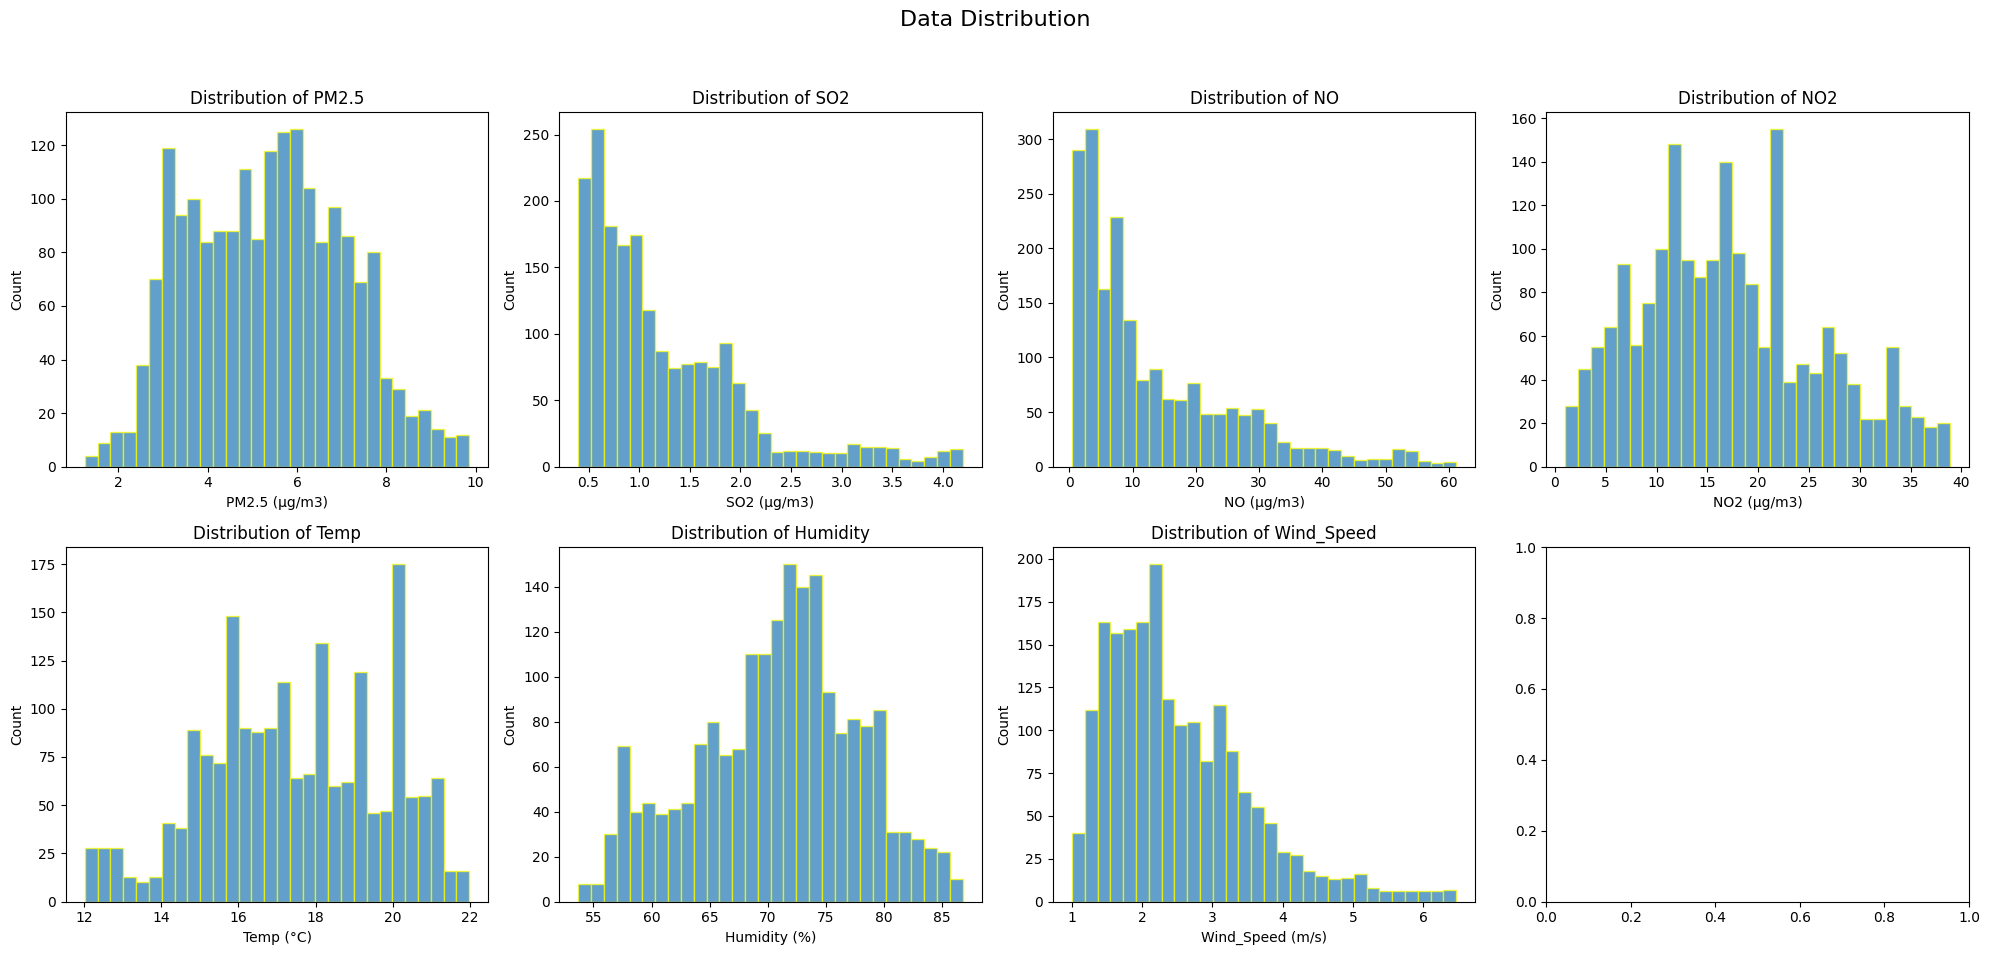

In [64]:
#change the index

df = df2.copy()
# Set start_time as index
df.set_index('start_time', inplace=True)

# Remove end_time column
df.drop(columns=['end_time'], inplace=True)

# Display the updated DataFrame
print(df.head())
df.info()

show_time_series_hist_plot(df,columns_to_plot = ["PM2.5", "SO2", "NO", "NO2", "Temp", "Humidity",  "Wind_Speed"])

In [65]:

#df_without_time = df.drop(columns=['start_time','end_time'])
df_without_time.describe().T

count        mean        std        min        25%         50%  \
SO2         1806.0    1.134659   0.603999   0.400000   0.640625    0.989583   
NO          1872.0   11.793610  10.334825   0.408333   3.349479    8.125000   
NO2         1944.0   17.168519   8.761585   1.035417  10.434896   16.379167   
Temp        1944.0   17.432099   2.270050  12.020833  15.895833   17.375000   
Humidity    1944.0   70.798765   6.985182  53.706250  66.101562   71.525000   
Wind_Dir    1923.0  175.697088  86.197476   5.500000  85.000000  206.500000   
Wind_Speed  1893.0    2.428359   0.885968   1.002083   1.731250    2.229167   
PM2.5       1944.0    5.361728   1.731481   1.250000   3.926562    5.431250   

                   75%         max  
SO2           1.548437    3.152083  
NO           18.190625   42.850000  
NO2          22.326563   38.852083  
Temp         19.229167   21.979167  
Humidity     75.486458   86.789583  
Wind_Dir    232.500000  356.000000  
Wind_Speed    3.054167    5.129167  
PM2.5         6.659375    9.856250

# **Step 2. Feature Selection**




## **2.1 Correlation Analysis.**

Parameters       Pearson_Correlation
lag1                      0.998725
lag2                      0.994965
NO2                       0.659111
NO                        0.636912
SO2                       0.573049
Temp                     -0.404201
Humidity                 -0.346694
Month_5                   0.32341
Month_3                  -0.224426
Wind_Speed               -0.215437
Wind_Type_NNE            -0.207006
Wind_Type_NE             -0.194272
Day_0                    -0.191282
Wind_Type_ENE            -0.18851
Wind_Type_SW              0.174952
Day_4                     0.173716
Wind_Type_SSW             0.144636
Day_1                    -0.129294
Day_5                     0.129241
Day_3                     0.129103
Month_4                  -0.123785
Day_2                    -0.0646946
Wind_Type_S               0.0604913
Month_6                  -0.0486361
Day_6                    -0.0486037
Wind_Type_NW              0.039739
Wind_Type_N               0.0341677
Wind_Type_WSW  

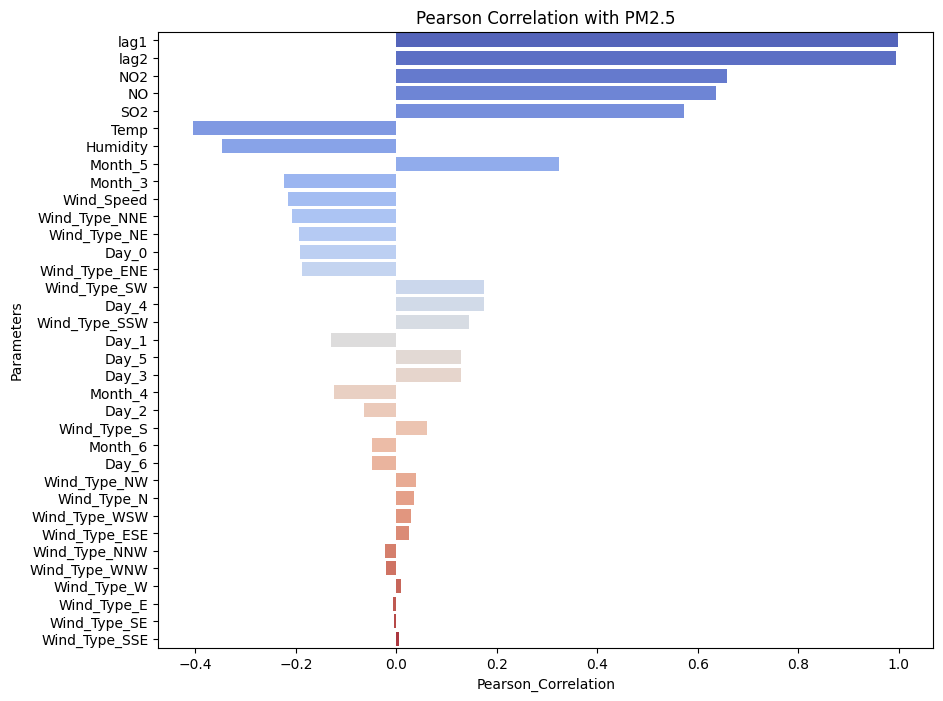

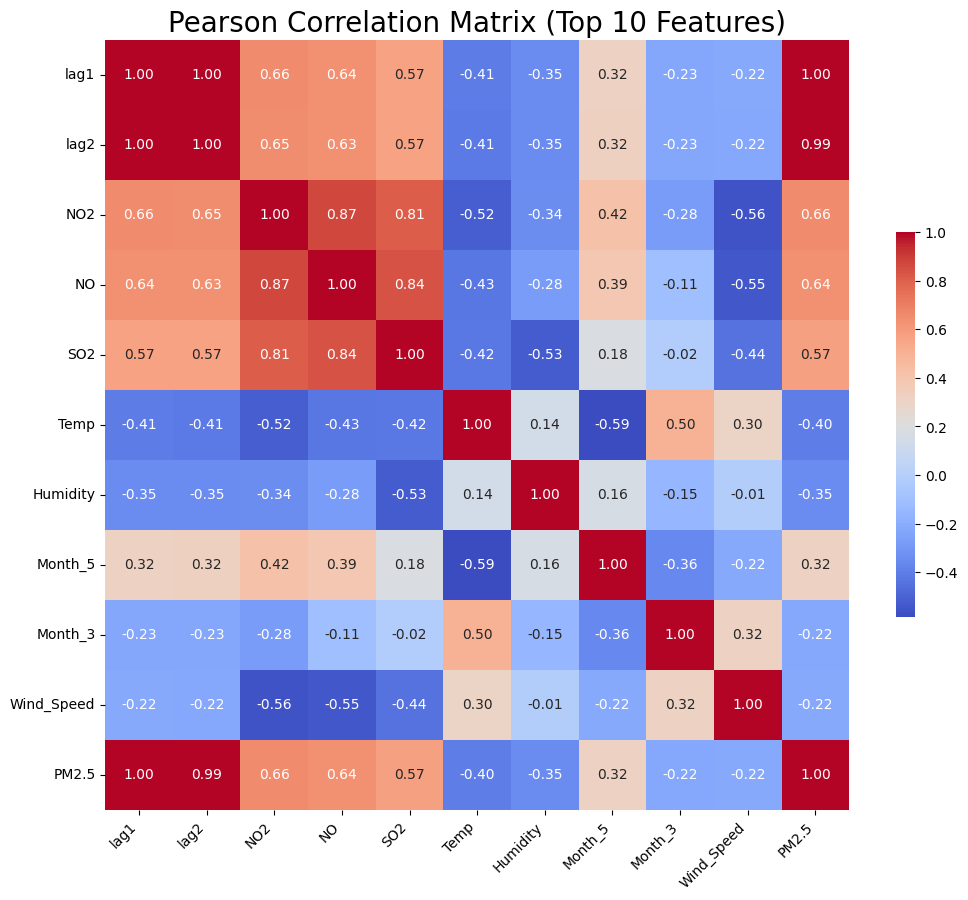

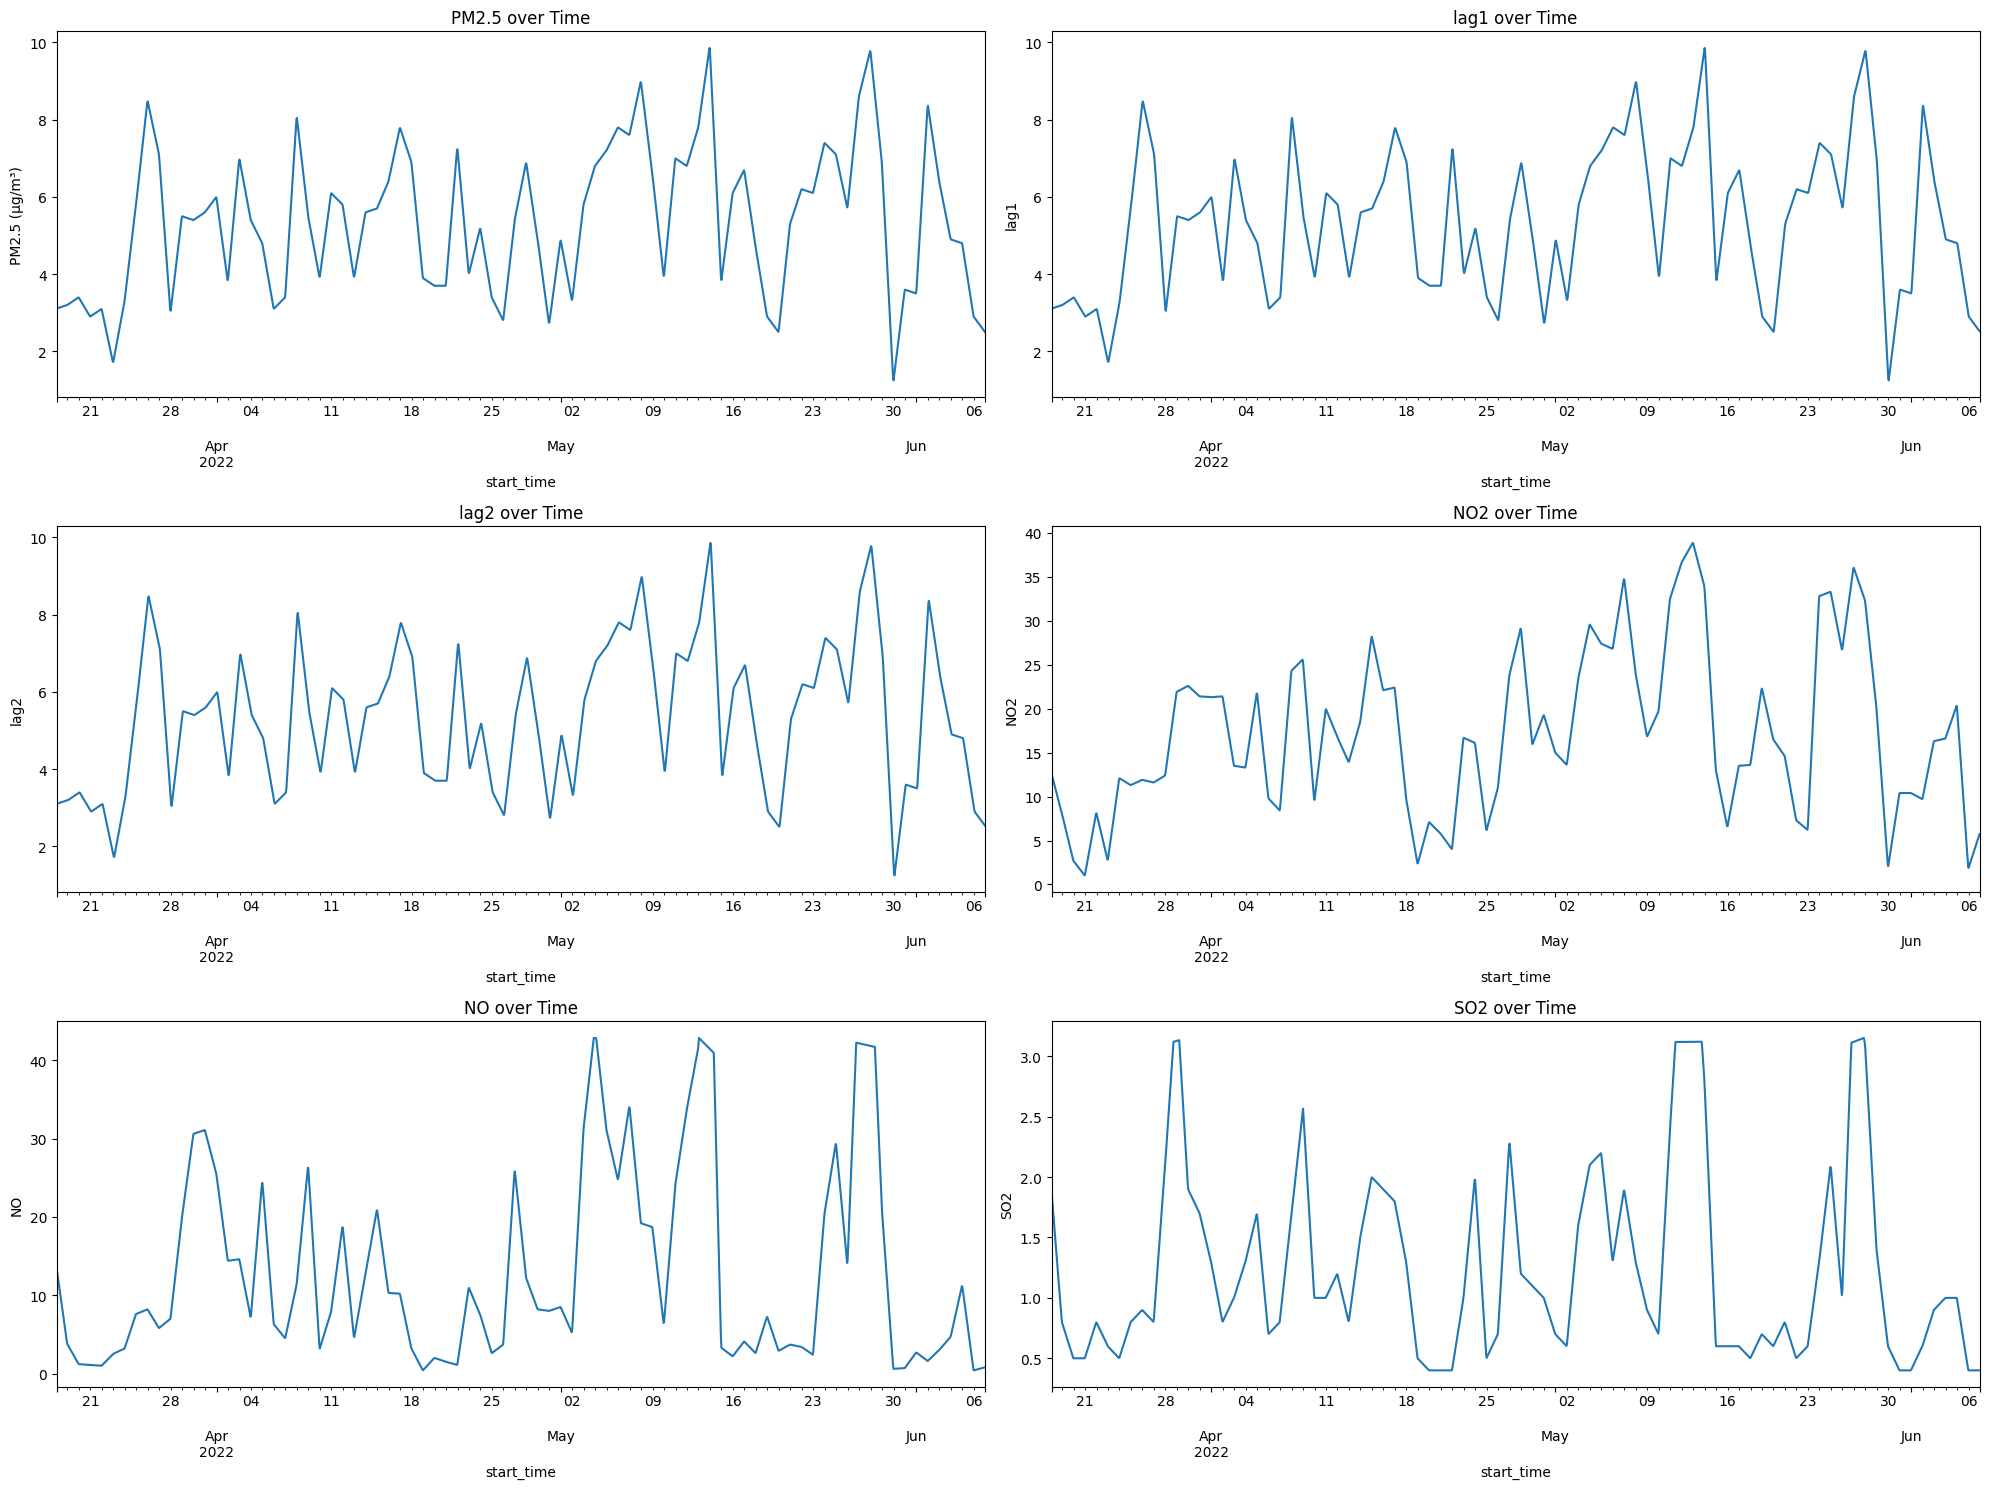

             PM2.5         lag1         lag2          NO2           NO  \
count  1942.000000  1942.000000  1942.000000  1942.000000  1942.000000   
mean      5.364053     5.364361     5.364658    17.172923    12.911059   
std       1.730855     1.730400     1.729961     8.765021    11.641963   
min       1.250000     1.250000     1.250000     1.035417     0.408333   
25%       3.931771     3.931771     3.931771    10.429687     3.443750   
50%       5.432292     5.432292     5.432292    16.381250     8.333333   
75%       6.661458     6.661458     6.661458    22.329687    19.256250   
max       9.856250     9.856250     9.856250    38.852083    42.850000   

               SO2  
count  1942.000000  
mean      1.239556  
std       0.724355  
min       0.400000  
25%       0.662500  
50%       1.007292  
75%       1.675000  
max       3.152083  


In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# Assuming df is the DataFrame after final preprocessing

# Calculate Pearson correlations
pearson_corr = df.corr(method='pearson')

# Extract Pearson correlations with PM2.5
pearson_corr_pm25 = pearson_corr.loc['PM2.5'].drop('PM2.5')

# Create a DataFrame to store the correlation results
corr_df = pd.DataFrame({
    'Parameters': pearson_corr_pm25.index,
    'Pearson_Correlation': pearson_corr_pm25.values,
})

# Order by absolute value of Pearson correlation while keeping the original values
corr_df['Absolute Correlation'] = corr_df['Pearson_Correlation'].abs()
corr_df = corr_df.sort_values(by='Absolute Correlation', ascending=False).drop(columns='Absolute Correlation')

# Print the correlation table
table = tabulate(corr_df, headers='keys', tablefmt='plain', showindex=False)
print(table)

# Visualize the ordered correlations with a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Pearson_Correlation', y='Parameters', data=corr_df, palette='coolwarm')
plt.title('Pearson Correlation with PM2.5')
plt.show()

# Select top 10 parameters based on absolute Pearson correlation with PM2.5
top_10_columns = corr_df.head(10)['Parameters'].tolist()

# Visualize the correlations with a heatmap for top 10 correlated features
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr.loc[top_10_columns + ['PM2.5'], top_10_columns + ['PM2.5']], annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10}, cbar_kws={'shrink': .5})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Pearson Correlation Matrix (Top 10 Features)', fontsize=20)
plt.show()

# Select top 5 parameters based on absolute Pearson correlation with PM2.5
top_5_columns = corr_df.head(5)['Parameters'].tolist()

# Visualize the variation of PM2.5 over time and the selected features
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Plot PM2.5 variation over time
df['PM2.5'].plot(ax=axs[0, 0], title='PM2.5 over Time')
axs[0, 0].set_ylabel('PM2.5 (µg/m³)')

# Plot the selected features variation over time
for i, col in enumerate(top_5_columns):
    df[col].plot(ax=axs[(i + 1) // 2, (i + 1) % 2], title=f'{col} over Time')
    axs[(i + 1) // 2, (i + 1) % 2].set_ylabel(col)

# Adjust the layout
plt.tight_layout()
plt.show()

# Provide summary statistics of PM2.5 and the chosen predictors
summary_stats = df[['PM2.5'] + top_5_columns].describe()
print(summary_stats)


In [67]:
df.describe().T


count       mean        std        min        25%        50%  \
SO2            1942.0   1.239556   0.724355   0.400000   0.662500   1.007292   
NO             1942.0  12.911059  11.641963   0.408333   3.443750   8.333333   
NO2            1942.0  17.172923   8.765021   1.035417  10.429687  16.381250   
Temp           1942.0  17.430484   2.270661  12.020833  15.895833  17.375000   
Humidity       1942.0  70.815182   6.969998  53.706250  66.125521  71.528125   
Wind_Speed     1942.0   2.499575   0.973683   1.002083   1.744271   2.257292   
PM2.5          1942.0   5.364053   1.730855   1.250000   3.931771   5.432292   
lag1           1942.0   5.364361   1.730400   1.250000   3.931771   5.432292   
lag2           1942.0   5.364658   1.729961   1.250000   3.931771   5.432292   
Wind_Type_E    1942.0   0.054068   0.226210   0.000000   0.000000   0.000000   
Wind_Type_ENE  1942.0   0.103502   0.304691   0.000000   0.000000   0.000000   
Wind_Type_ESE  1942.0   0.031411   0.174470   0.000000   0.000000   0.000000   
Wind_Type_N    1942.0   0.004119   0.064067   0.000000   0.000000   0.000000   
Wind_Type_NE   1942.0   0.080844   0.272666   0.000000   0.000000   0.000000   
Wind_Type_NNE  1942.0   0.039650   0.195185   0.000000   0.000000   0.000000   
Wind_Type_NNW  1942.0   0.018023   0.133067   0.000000   0.000000   0.000000   
Wind_Type_NW   1942.0   0.043769   0.204634   0.000000   0.000000   0.000000   
Wind_Type_S    1942.0   0.058187   0.234158   0.000000   0.000000   0.000000   
Wind_Type_SE   1942.0   0.027806   0.164460   0.000000   0.000000   0.000000   
Wind_Type_SSE  1942.0   0.036560   0.187728   0.000000   0.000000   0.000000   
Wind_Type_SSW  1942.0   0.141092   0.348206   0.000000   0.000000   0.000000   
Wind_Type_SW   1942.0   0.200824   0.400720   0.000000   0.000000   0.000000   
Wind_Type_W    1942.0   0.046859   0.211391   0.000000   0.000000   0.000000   
Wind_Type_WNW  1942.0   0.034501   0.182558   0.000000   0.000000   0.000000   
Wind_Type_WSW  1942.0   0.078785   0.269472   0.000000   0.000000   0.000000   
Month_3        1942.0   0.171988   0.377467   0.000000   0.000000   0.000000   
Month_4        1942.0   0.370752   0.483131   0.000000   0.000000   0.000000   
Month_5        1942.0   0.383110   0.486270   0.000000   0.000000   0.000000   
Month_6        1942.0   0.074150   0.262083   0.000000   0.000000   0.000000   
Day_0          1942.0   0.148301   0.355489   0.000000   0.000000   0.000000   
Day_1          1942.0   0.135942   0.342816   0.000000   0.000000   0.000000   
Day_2          1942.0   0.135942   0.342816   0.000000   0.000000   0.000000   
Day_3          1942.0   0.135942   0.342816   0.000000   0.000000   0.000000   
Day_4          1942.0   0.147271   0.354467   0.000000   0.000000   0.000000   
Day_5          1942.0   0.148301   0.355489   0.000000   0.000000   0.000000   
Day_6          1942.0   0.148301   0.355489   0.000000   0.000000   0.000000   

                     75%        max  
SO2             1.675000   3.152083  
NO             19.256250  42.850000  
NO2            22.329687  38.852083  
Temp           19.229167  21.979167  
Humidity       75.488542  86.789583  
Wind_Speed      3.100000   5.129167  
PM2.5           6.661458   9.856250  
lag1            6.661458   9.856250  
lag2            6.661458   9.856250  
Wind_Type_E     0.000000   1.000000  
Wind_Type_ENE   0.000000   1.000000  
Wind_Type_ESE   0.000000   1.000000  
Wind_Type_N     0.000000   1.000000  
Wind_Type_NE    0.000000   1.000000  
Wind_Type_NNE   0.000000   1.000000  
Wind_Type_NNW   0.000000   1.000000  
Wind_Type_NW    0.000000   1.000000  
Wind_Type_S     0.000000   1.000000  
Wind_Type_SE    0.000000   1.000000  
Wind_Type_SSE   0.000000   1.000000  
Wind_Type_SSW   0.000000   1.000000  
Wind_Type_SW    0.000000   1.000000  
Wind_Type_W     0.000000   1.000000  
Wind_Type_WNW   0.000000   1.000000  
Wind_Type_WSW   0.000000   1.000000  
Month_3         0.000000   1.000000  
Month_4         1.000000   1.

In [68]:

selected_features = corr_df['Parameters'][:5].tolist()
print("Selected Features:", selected_features)

Selected Features: ['lag1', 'lag2', 'NO2', 'NO', 'SO2']


# **Step 3. Experimental Methods**



    * Normalization Data.

    * Data segment

Use 70% of the data for training and the rest for testing the MLP and LSTM models. Use a Workflow diagram to illustrate the process of predicting PM concentrations using the MLP and LSTM models.

In [69]:

# Initialize MinMaxScaler
my_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df = my_scaler.fit_transform(df[selected_features + ['PM2.5']])
scaled_df = pd.DataFrame(scaled_df, columns=selected_features + ['PM2.5'])

# Extract features and target values
X_scaler = scaled_df[selected_features].values
y_scaler = scaled_df['PM2.5'].values


# Split the data into training and testing sets based on time order
train_size = int(len(X_scaler) * 0.7)
X_train, X_test = X_scaler[:train_size], X_scaler[train_size:]
y_train, y_test = y_scaler[:train_size], y_scaler[train_size:]


# Get the corresponding time indices for the train and test sets
time_indices = df.index
# Adjust time_test for sliding window
time_test = time_indices[train_size + N_STEPS:]


#===


# Display the normalized data
print(scaled_df.describe())


              lag1         lag2          NO2           NO          SO2  \
count  1942.000000  1942.000000  1942.000000  1942.000000  1942.000000   
mean      0.478067     0.478101     0.426730     0.294586     0.305062   
std       0.201063     0.201012     0.231777     0.274305     0.263202   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.311607     0.311607     0.248416     0.071520     0.095382   
50%       0.485960     0.485960     0.405796     0.186727     0.220666   
75%       0.628782     0.628782     0.563092     0.444090     0.463285   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             PM2.5  
count  1942.000000  
mean      0.478031  
std       0.201116  
min       0.000000  
25%       0.311607  
50%       0.485960  
75%       0.628782  
max       1.000000  


# **Step 4. Multilayer Perceptron (MLP)**

## 4.2 Learning Rate Analysis

In [70]:
from sklearn.model_selection import KFold, cross_val_score

# Define a function to evaluate the model with K-Fold Cross-Validation
def evaluate_model(learning_rate):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mlp = MLPRegressor(hidden_layer_sizes=(25,), learning_rate_init=learning_rate, max_iter=1000, random_state=42)

    mse_scores = -cross_val_score(mlp, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(mlp, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(mlp, X_train, y_train, cv=kf, scoring='r2')

    return mse_scores.mean(), rmse_scores.mean(), mae_scores.mean(), r2_scores.mean()

# List of learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

for lr in learning_rates:
    mse, rmse, mae, r2 = evaluate_model(lr)
    results.append((lr, mse, rmse, mae, r2))

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Learning Rate', 'MSE', 'RMSE', 'MAE', 'R²'])

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


The best learning rate is:  0.5
Results for the best learning rate (0.5):
MSE: 0.00016288636013286672
RMSE: 0.012744600927936871
MAE: 0.010083069025002365
R²: 0.9953171257665117
   Learning Rate       MSE      RMSE       MAE        R²
0         0.0001  0.029127  0.170267  0.135444  0.162160
1         0.0010  0.003622  0.060037  0.046194  0.895767
2         0.0100  0.000239  0.015424  0.012209  0.993143
3         0.1000  0.000216  0.014667  0.011624  0.993812
4         0.5000  0.000163  0.012745  0.010083  0.995317
5         1.0000  0.021789  0.129311  0.107560  0.364322



The best learning rate for the MLPRegressor model, based on the tested values, is 0.001, which resulted in the lowest MSE of 3.171270. Additionally, this learning rate provided an RMSE of 1.780806, an MAE of 1.318530, and an R² score of 0.311761. This rate should be used for the highest performance on the testing dataset.

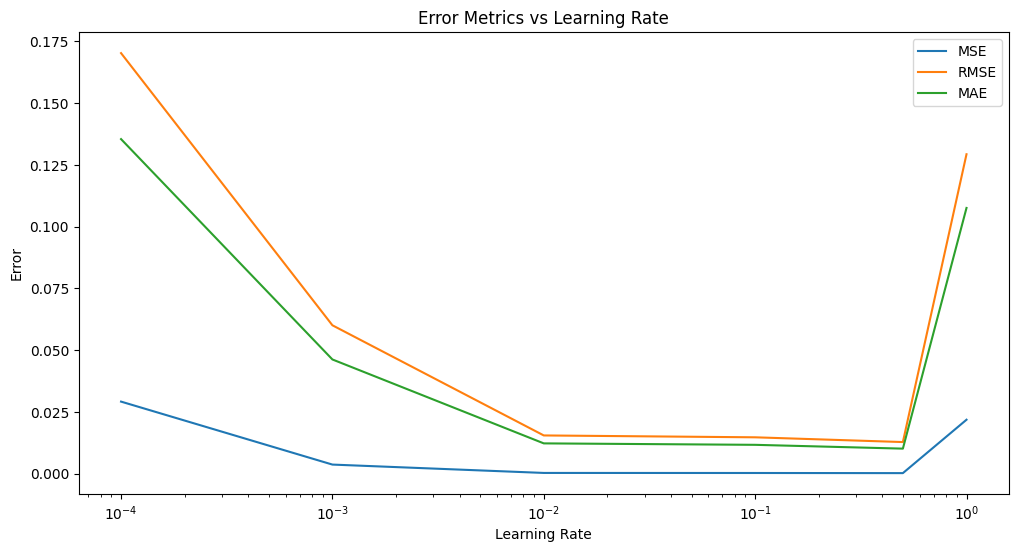

In [71]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 4.3 Neurons Distribution Analysis

The best configuration is:
Layer 1 neurons: 7.0, Layer 2 neurons: 18.0
MSE: 0.005750852425431625
RMSE: 0.06751266588873187
MAE: 0.05366297068518429
R²: 0.8539997716553371
    Neurons in Layer 1  Neurons in Layer 2       MSE      RMSE       MAE  \
0                   24                   1  0.041534  0.203776  0.169516   
1                   23                   2  0.040619  0.201514  0.167609   
2                   22                   3  0.040655  0.201613  0.167473   
3                   21                   4  0.040504  0.201228  0.167483   
4                   20                   5  0.040582  0.201422  0.167521   
5                   19                   6  0.040531  0.201292  0.167331   
6                   18                   7  0.040472  0.201143  0.167224   
7                   17                   8  0.041004  0.202436  0.168616   
8                   16                   9  0.024227  0.126728  0.104875   
9                   15                  10  0.028774  0.153940  0.129

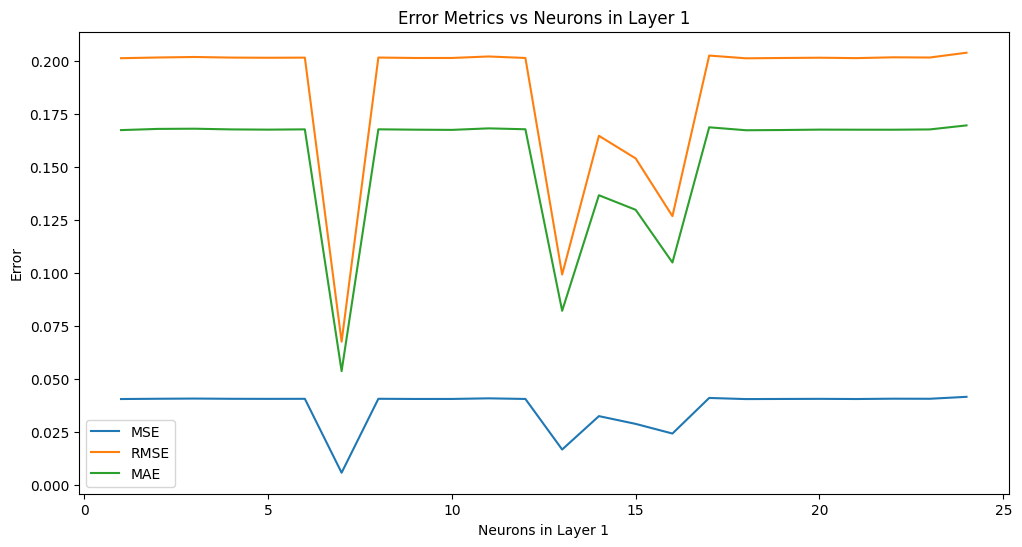

In [72]:
#determine the optimal distribution of neurons across

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k = 25
results = []

if CALCU_HYPER_PARAMETERS:
    for i in range(1, k):  # i ranges from 1 to k-1
        neurons_layer1 = k - i
        neurons_layer2 = i
        mse_list, rmse_list, mae_list, r2_list = [], [], [], []

        for train_index, test_index in kf.split(X_scaler):
            X_train, X_test = X_scaler[train_index], X_scaler[test_index]
            y_train, y_test = y_scaler[train_index], y_scaler[test_index]

            # Create the MLPRegressor model with the specified neurons in two hidden layers
            mlp = MLPRegressor(hidden_layer_sizes=(neurons_layer1, neurons_layer2), learning_rate_init=My_Learning_Rate, max_iter=1000, random_state=42)

            # Train the model
            mlp.fit(X_train, y_train)

            # Predict on the testing set
            y_pred = mlp.predict(X_test)

            # Calculate the mean squared error
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            mse_list.append(mse)
            rmse_list.append(rmse)
            mae_list.append(mae)
            r2_list.append(r2)

        results.append((neurons_layer1, neurons_layer2, np.mean(mse_list), np.mean(rmse_list), np.mean(mae_list), np.mean(r2_list)))

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results, columns=['Neurons in Layer 1', 'Neurons in Layer 2', 'MSE', 'RMSE', 'MAE', 'R²'])

    # Highlight the best configuration
    best_config = results_df.loc[results_df['MSE'].idxmin()]
    print("The best configuration is:")
    print(f"Layer 1 neurons: {best_config['Neurons in Layer 1']}, Layer 2 neurons: {best_config['Neurons in Layer 2']}")
    print(f"MSE: {best_config['MSE']}")
    print(f"RMSE: {best_config['RMSE']}")
    print(f"MAE: {best_config['MAE']}")
    print(f"R²: {best_config['R²']}")

    # Display the results
    print(results_df)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Neurons in Layer 1'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Neurons in Layer 1'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Neurons in Layer 1'], results_df['MAE'], label='MAE')
    plt.xlabel('Neurons in Layer 1')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Neurons in Layer 1')
    plt.legend()
    plt.show()


# **Step 5. Long Short-Term Memory (LSTM)**

## 5.2 Best Cost Function Analysis

In [73]:


def create_lstm_datasets(x_scaler, y_scaler, n_steps=N_STEPS):
    # Function to create sequences
    def create_sequences(data, labels, n_steps):
        sequences = []
        seq_labels = []
        for i in range(len(data) - n_steps):
            seq = data[i:i + n_steps]
            sequences.append(seq)
            seq_labels.append(labels[i + n_steps])
        return np.array(sequences), np.array(seq_labels)

    # Create sequences
    X_sequences, y_sequences = create_sequences(x_scaler, y_scaler, n_steps)

    # Calculate split index, keep the same split index as mlp,very important
    split_index = int((len(X_sequences)+ n_steps) * 0.7)

    # Split the sequences into train and test sets based on time order
    X_train_lstm, X_test_lstm = X_sequences[:split_index], X_sequences[split_index:]
    y_train_lstm, y_test_lstm = y_sequences[:split_index], y_sequences[split_index:]

    # Define input shape
    my_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

    return X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, my_input_shape


# Default Value
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, my_input_shape = create_lstm_datasets(X_scaler, y_scaler)





print("time_test shape:", time_test.shape)
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("y_test_lstm shape:", y_test_lstm.shape)
print("Input shape for LSTM:", my_input_shape)



# Custom callback to measure epoch time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


# Define different loss functions
loss_functions = {
    'MSE': MeanSquaredError(),
    'MAE': MeanAbsoluteError(),
    'MSLE': MeanSquaredLogarithmicError(),
    'Huber': Huber()
}


# Build the LSTM model


# Function to build LSTM model with stateful mode


def build_custom_lstm_model(input_shape_custom
                            , learning_rate_custom=0.01
                            , loss_function=Huber()
                            , neurons_num=1 ):
    model = Sequential()
    model.add(LSTM(neurons_num, return_sequences=False, input_shape=input_shape_custom))  # Set return_sequences=False
    model.add(Dropout(0.2))
    model.add(Dense(neurons_num, activation='relu', kernel_regularizer=l1(0.01)))  # Added L1 regularization
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate_custom), loss=loss_function)

    return model



def build_custom_lstm_model1(input_shape_custom
                            , learning_rate_custom=0.01
                            , loss_function=Huber()
                            , neurons_num=1 ):
    model = Sequential()
    model.add(LSTM(neurons_num, return_sequences=True, input_shape=input_shape_custom))
    model.add(LSTM(neurons_num))
    model.add(Dense(neurons_num, activation='relu', kernel_regularizer=l1(0.01)))  # Added L1 regularization
    model.add(Dropout(0.1))
    model.add(Dense(neurons_num, activation='relu', kernel_regularizer=l2(0.01)))  # Added L2 regularization
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=learning_rate_custom), loss=loss_function)

    return model

def build_custom_lstm_model2(input_shape_custom
                            , learning_rate_custom=0.01
                            , loss_function=MeanSquaredError()
                            , neurons_num=1 ):
    model = Sequential()
    model.add(LSTM(units=neurons_num, return_sequences=True, input_shape=input_shape_custom))
    model.add(Dropout(0.2))

    model.add(LSTM(units=neurons_num, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=neurons_num))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate_custom), loss=loss_function)
    return model

def build_custom_lstm_model3(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))  # Reduced number of units
    model.add(LSTM(64))  # Reduced number of units
    model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01)))  # Added L1 regularization
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Added L2 regularization
    model.add(Dense(8, activation='linear'))

    model.compile(optimizer='adam', loss='mse')

    return model

#  select_continuous_sub_data for lstm
def select_continuous_sub_data(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm):


    train_length = 240#2400
    test_length = 12#120
    #train_length = len(X_train_lstm) // 3
    #test_length = len(X_test_lstm) // 3


    start_train = 0
    start_test = 0
    start_train = np.random.randint(0, len(X_train_lstm) - train_length)
    start_test = np.random.randint(0, len(X_test_lstm) - test_length)


    X_train_segment = X_train_lstm[start_train:start_train + train_length]
    y_train_segment = y_train_lstm[start_train:start_train + train_length]
    X_test_segment = X_test_lstm[start_test:start_test + test_length]
    y_test_segment = y_test_lstm[start_test:start_test + test_length]

    return X_train_segment, y_train_segment, X_test_segment, y_test_segment



# Inverse transform function
def inverse_transform_predictions(predictions, scaler, X_data):
    predictions_flat = predictions.reshape(-1, 1)
    predictions_actual_flat = scaler.inverse_transform(np.concatenate([np.zeros((predictions_flat.shape[0], X_data.shape[2])), predictions_flat], axis=1))[:, -1]
    predictions_actual = predictions_actual_flat.reshape(predictions.shape)
    return predictions_actual

time_test shape: (581,)
X_train_lstm shape: (1359, 2, 5)
X_test_lstm shape: (581, 2, 5)
y_train_lstm shape: (1359,)
y_test_lstm shape: (581,)
Input shape for LSTM: (2, 5)


In [74]:
# Predict with LSTM
#model, lstm_predictions_actual, y_test_lstm_actual = train_lstm(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, best_epoch, best_batch_size, best_neuron_count)


## 5.3 Best Epoch Analysis

Testing with Epochs: 20


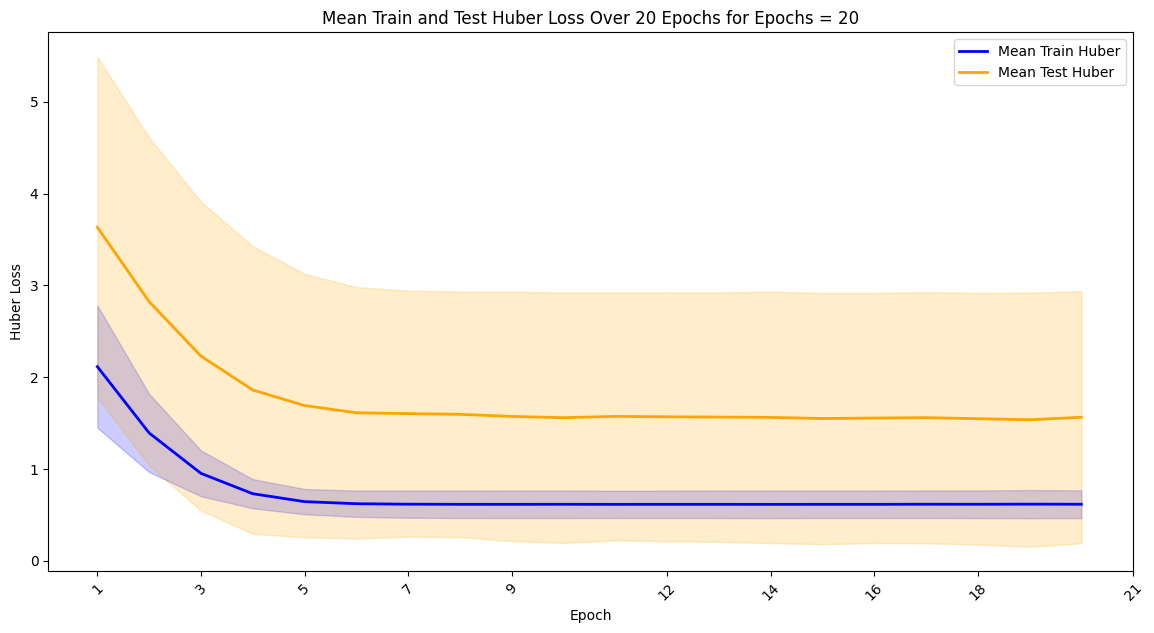

Testing with Epochs: 60


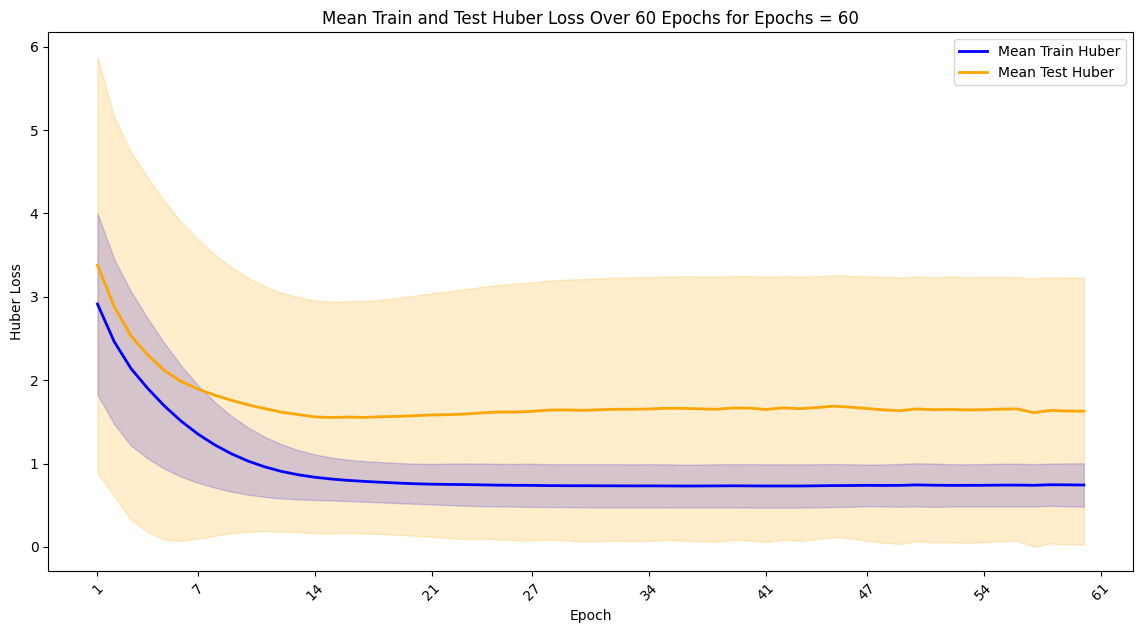

Testing with Epochs: 100


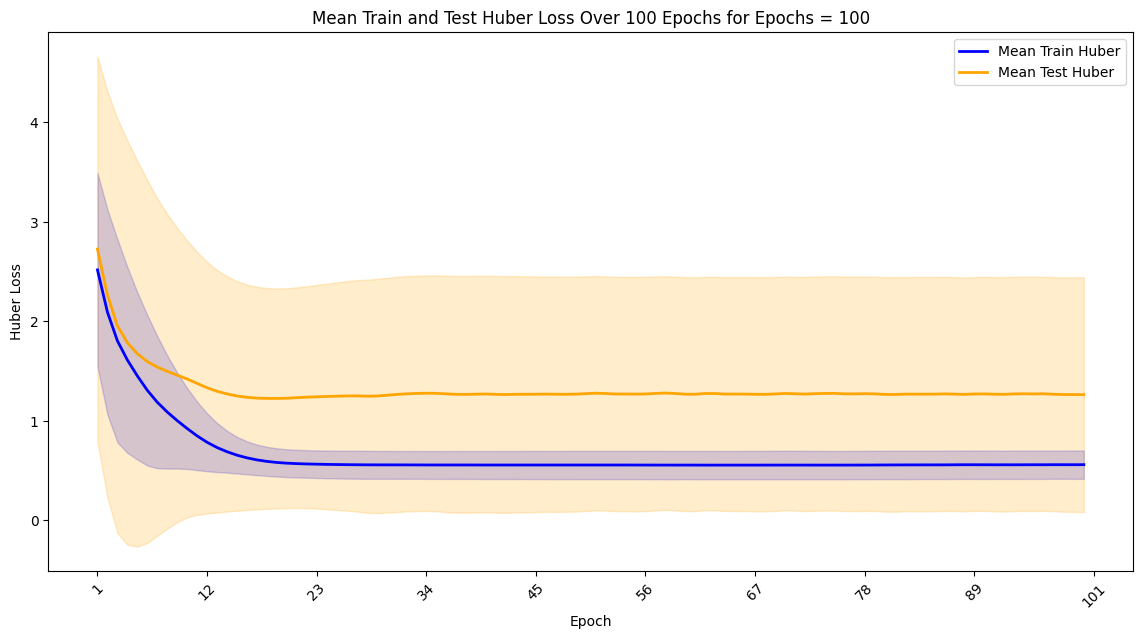

Testing with Epochs: 200


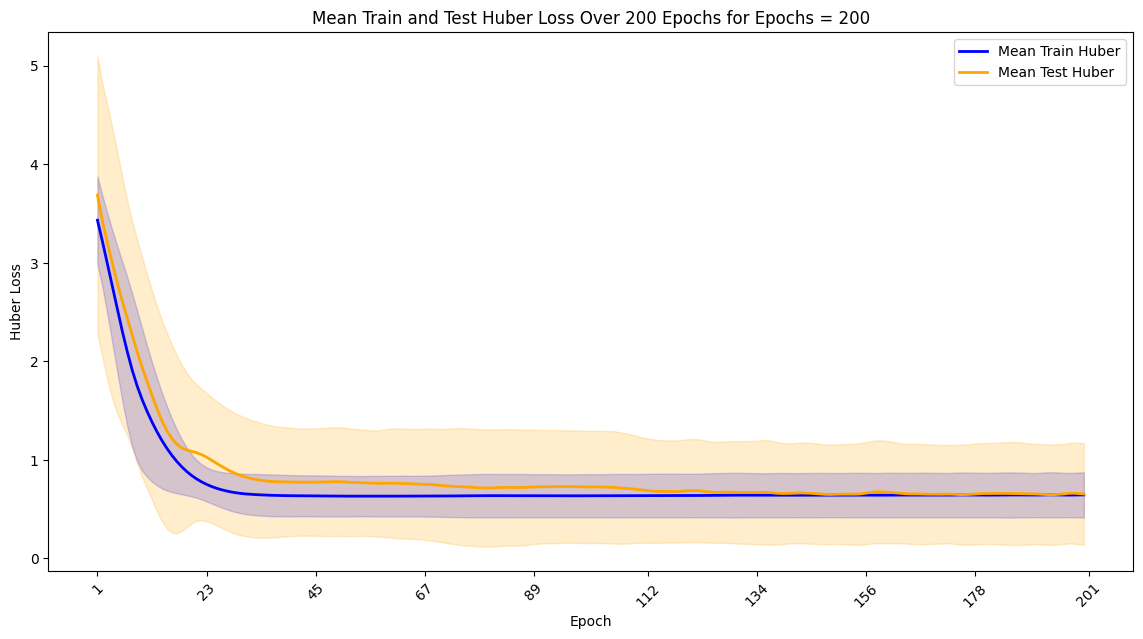

Testing with Epochs: 500


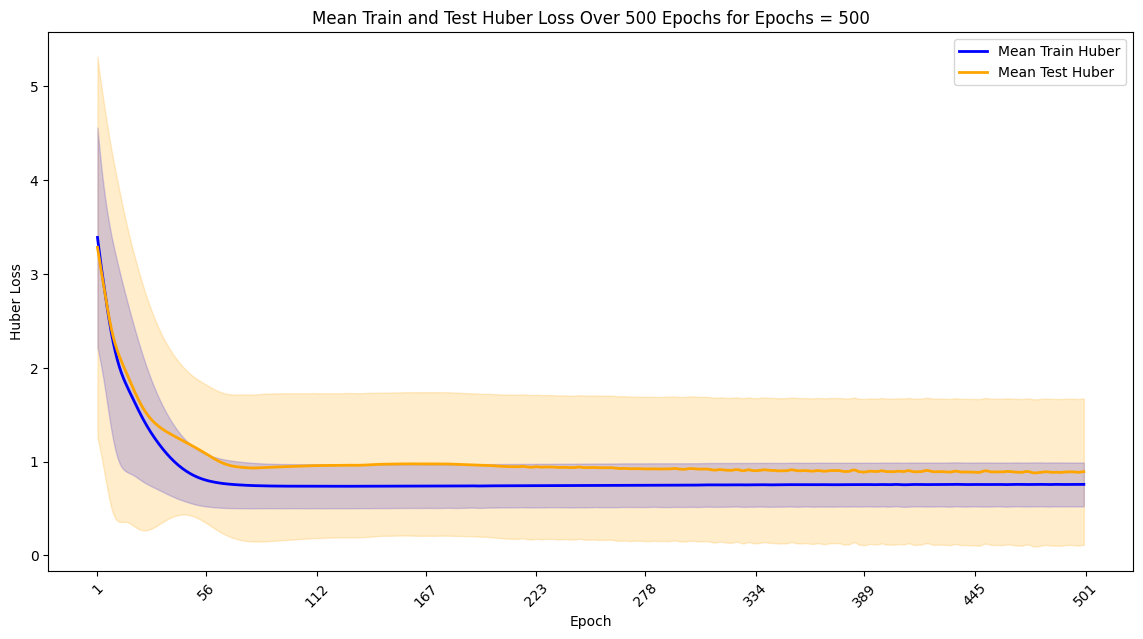

Summary of Test Huber Loss and Time for all Epochs configurations:
    Epochs  Test Huber Mean  Test Huber Std Dev  Test Huber Min  \
0      20         1.562835            1.372978        0.090328   
1      60         1.627785            1.600514        0.259126   
2     100         1.263646            1.178932        0.016680   
3     200         0.654080            0.514997        0.026291   
4     500         0.892497            0.779357        0.081133   

   Test Huber Max  Time Mean  Time Std Dev   Time Min   Time Max  
0        4.629751   3.689531      0.029572   3.624976   3.730860  
1        4.795913   6.054313      0.252607   5.878156   6.791901  
2        3.323727   9.385436      0.364749   9.145170  10.399630  
3        1.742128  16.444361      0.344073  15.990824  17.036364  
4        2.242917  36.588192      0.677120  35.509955  37.742201  


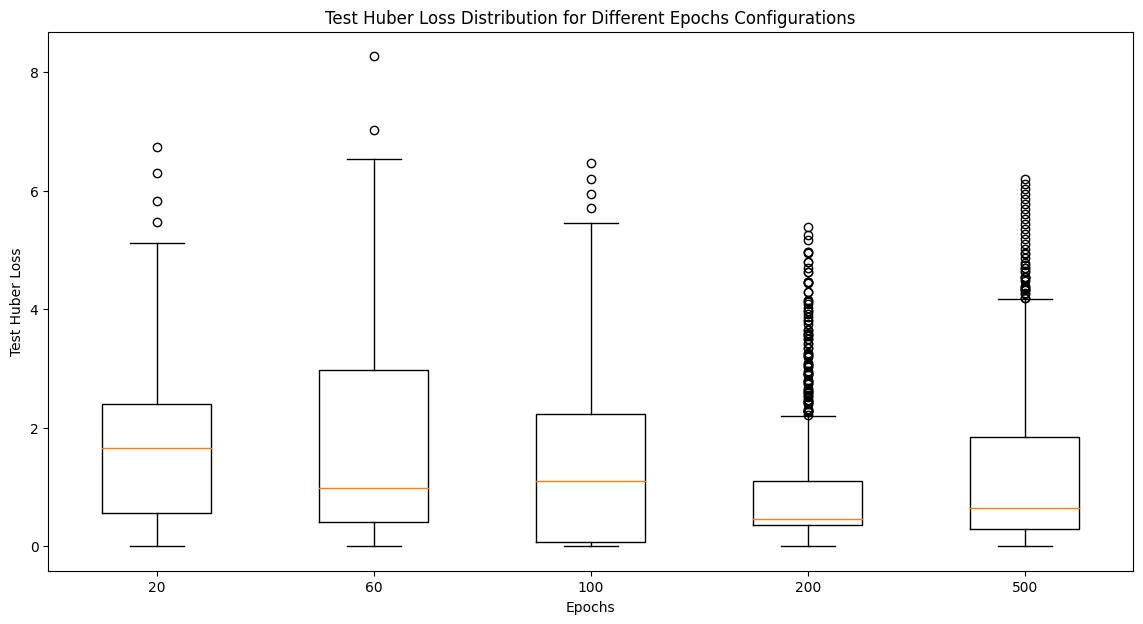

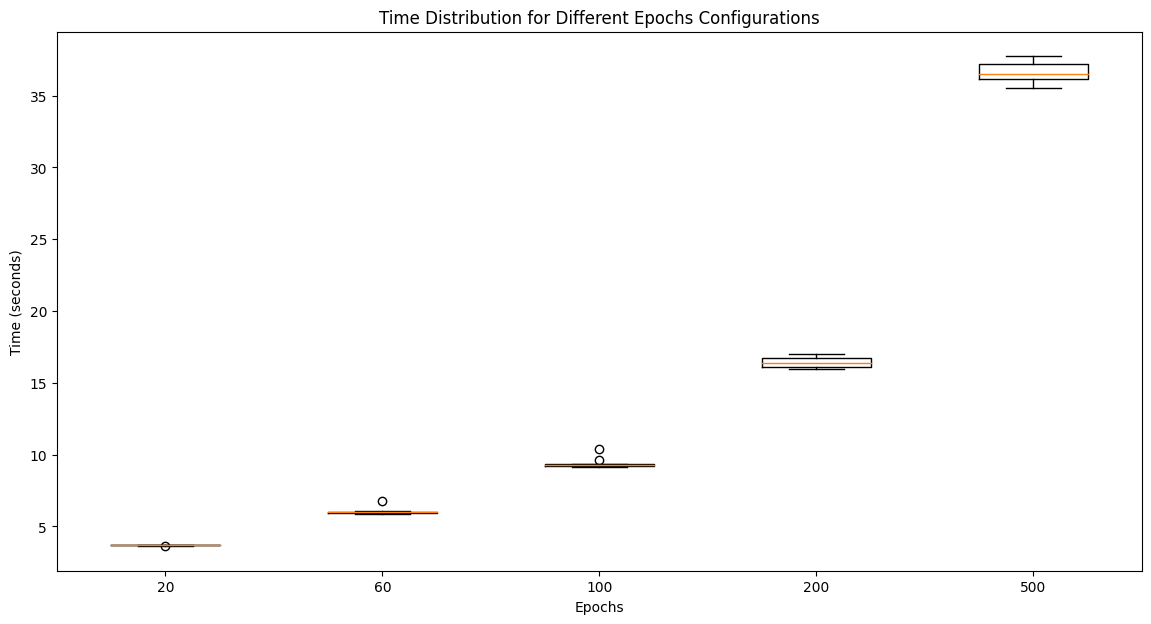

In [75]:
MODEL_RUN_COUNT = 10
# Function to fit model and calculate Huber loss for each epoch
def fit_and_evaluate_epochs(model, X_train_segment, y_train_segment, X_test_segment, y_test_segment, epochs, batch_size, scaler):
    train_huber = []
    test_huber = []
    epoch_times = []

    huber_loss = Huber()

    for epoch in range(epochs):
        start_time = time.time()
        history = model.fit(X_train_segment, y_train_segment, epochs=1, batch_size=batch_size, verbose=0)
        end_time = time.time()

        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)

        # Predict on train and test sets
        y_train_pred = model.predict(X_train_segment, verbose=0)
        y_test_pred = model.predict(X_test_segment, verbose=0)

        # Inverse transform predictions
        y_train_pred_actual = inverse_transform_predictions(y_train_pred, scaler, X_train_segment)
        y_test_pred_actual = inverse_transform_predictions(y_test_pred, scaler, X_test_segment)

        # Inverse transform actual values
        y_train_actual = inverse_transform_predictions(y_train_segment, scaler, X_train_segment)
        y_test_actual = inverse_transform_predictions(y_test_segment, scaler, X_test_segment)

        # Calculate Huber loss for train and test sets
        train_huber.append(np.mean(huber_loss(y_train_actual, y_train_pred_actual).numpy()))
        test_huber.append(np.mean(huber_loss(y_test_actual, y_test_pred_actual).numpy()))

    return train_huber, test_huber, epoch_times

# Function to evaluate model with different parameter configurations
def evaluate_model_with_parameters(param_arr, param_name, param_func, fixed_epochs=None, fixed_batch_size=None):
    all_test_huber_summary = []
    all_test_huber_combined = []
    all_times_combined = []

    for param in param_arr:
        print(f"Testing with {param_name}: {param}")

        epochs = fixed_epochs if fixed_epochs is not None else param
        batch_size = fixed_batch_size if fixed_batch_size is not None else param

        all_train_huber = np.zeros((MODEL_RUN_COUNT, epochs))
        all_test_huber = np.zeros((MODEL_RUN_COUNT, epochs))
        all_epoch_times = np.zeros((MODEL_RUN_COUNT, epochs))

        for run in range(MODEL_RUN_COUNT):
            model = param_func(param)

            # Randomly select continuous sub-data segments
            X_train_segment, y_train_segment, X_test_segment, y_test_segment = select_continuous_sub_data(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

            # Fit model and calculate Huber loss for each epoch
            train_huber, test_huber, epoch_times = fit_and_evaluate_epochs(model, X_train_segment, y_train_segment, X_test_segment, y_test_segment, epochs, batch_size, my_scaler)
            all_train_huber[run] = train_huber
            all_test_huber[run] = test_huber
            all_epoch_times[run] = epoch_times

        all_test_huber_combined.append(all_test_huber.flatten())
        all_times_combined.append(np.sum(all_epoch_times, axis=1))

        # Calculate summary statistics for test Huber loss
        summary_stats = {
            param_name: param,
            'Test Huber Mean': np.mean(all_test_huber, axis=0)[-1],
            'Test Huber Std Dev': np.std(all_test_huber, axis=0)[-1],
            'Test Huber Min': np.min(all_test_huber, axis=0)[-1],
            'Test Huber Max': np.max(all_test_huber, axis=0)[-1],
            'Time Mean': np.mean(np.sum(all_epoch_times, axis=1)),
            'Time Std Dev': np.std(np.sum(all_epoch_times, axis=1)),
            'Time Min': np.min(np.sum(all_epoch_times, axis=1)),
            'Time Max': np.max(np.sum(all_epoch_times, axis=1))
        }

        all_test_huber_summary.append(summary_stats)

        # Plot the Huber loss scores for each epoch
        plt.figure(figsize=(14, 7))
        mean_train_huber = np.mean(all_train_huber, axis=0)
        mean_test_huber = np.mean(all_test_huber, axis=0)

        plt.plot(range(1, epochs + 1), mean_train_huber, label='Mean Train Huber', linewidth=2, color='blue')
        plt.plot(range(1, epochs + 1), mean_test_huber, label='Mean Test Huber', linewidth=2, color='orange')
        plt.fill_between(range(1, epochs + 1), mean_train_huber - np.std(all_train_huber, axis=0), mean_train_huber + np.std(all_train_huber, axis=0), alpha=0.2, color='blue')
        plt.fill_between(range(1, epochs + 1), mean_test_huber - np.std(all_test_huber, axis=0), mean_test_huber + np.std(all_test_huber, axis=0), alpha=0.2, color='orange')

        plt.xlabel('Epoch')
        plt.ylabel('Huber Loss')
        plt.title(f'Mean Train and Test Huber Loss Over {epochs} Epochs for {param_name} = {param}')


        # Generate x-ticks for 10 evenly spaced points
        x_ticks = np.linspace(1, epochs+1, num=10, dtype=int)

        # Adjust x-ticks to show only 10 points
        plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)

        plt.legend()
        plt.show()

    # Combine all summaries into a single DataFrame and display
    all_test_huber_summary_df = pd.DataFrame(all_test_huber_summary)
    print(f"Summary of Test Huber Loss and Time for all {param_name} configurations:\n", all_test_huber_summary_df)

    # Plot the box plot for all test Huber loss
    plt.figure(figsize=(14, 7))
    plt.boxplot(all_test_huber_combined, labels=[str(param) for param in param_arr])
    plt.xlabel(param_name)
    plt.ylabel('Test Huber Loss')
    plt.title(f'Test Huber Loss Distribution for Different {param_name} Configurations')
    plt.show()

    # Plot the box plot for all times
    plt.figure(figsize=(14, 7))
    plt.boxplot(all_times_combined, labels=[str(param) for param in param_arr])
    plt.xlabel(param_name)
    plt.ylabel('Time (seconds)')
    plt.title(f'Time Distribution for Different {param_name} Configurations')
    plt.show()

# Main logic
if CALCU_HYPER_PARAMETERS:
    # Example usage to find best epochs
    epochs_arr = [20, 60,100,200,500]  # Example epochs to test
    evaluate_model_with_parameters(epochs_arr, 'Epochs', lambda x: build_custom_lstm_model(my_input_shape))


## 5.4 Batch Size Analysis

Testing with Batch Size: 4


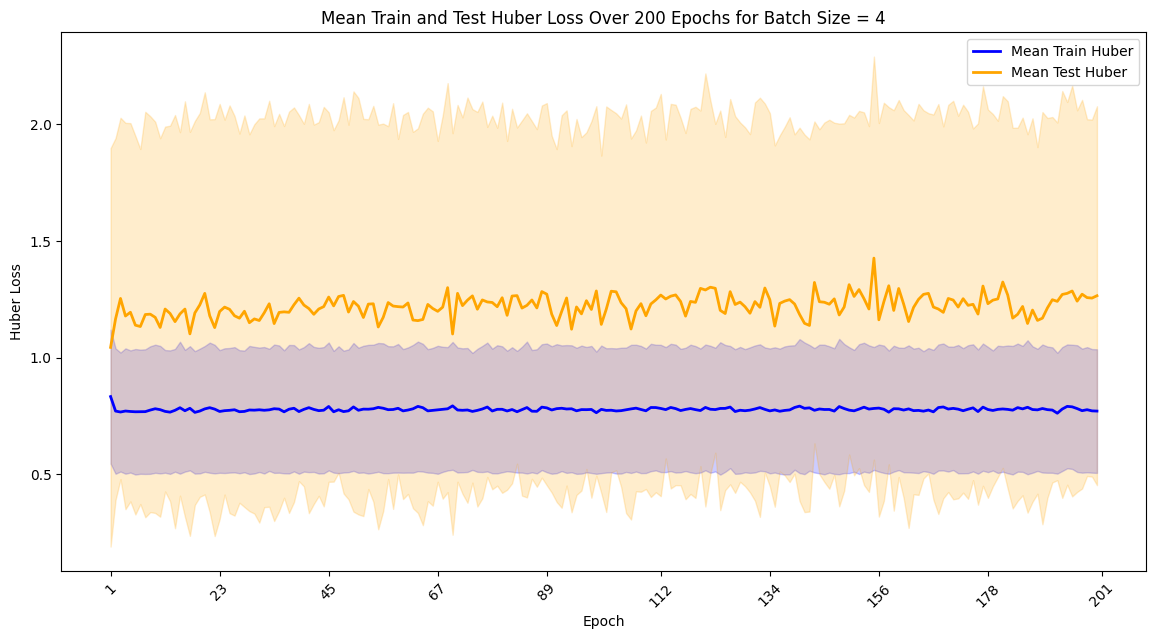

Testing with Batch Size: 8


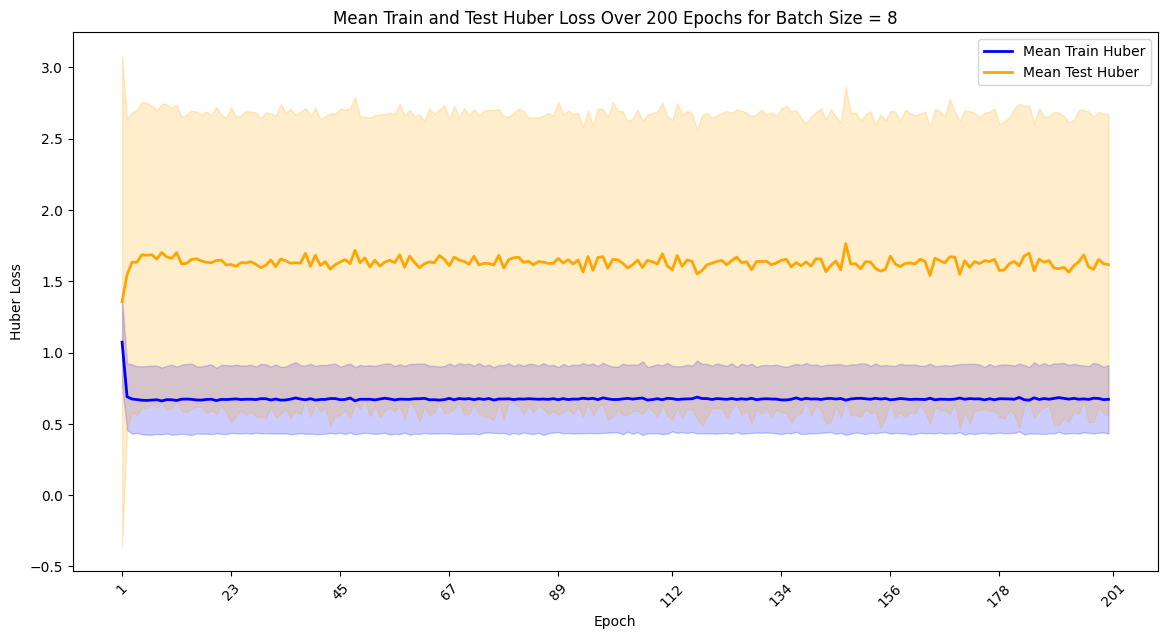

Testing with Batch Size: 16


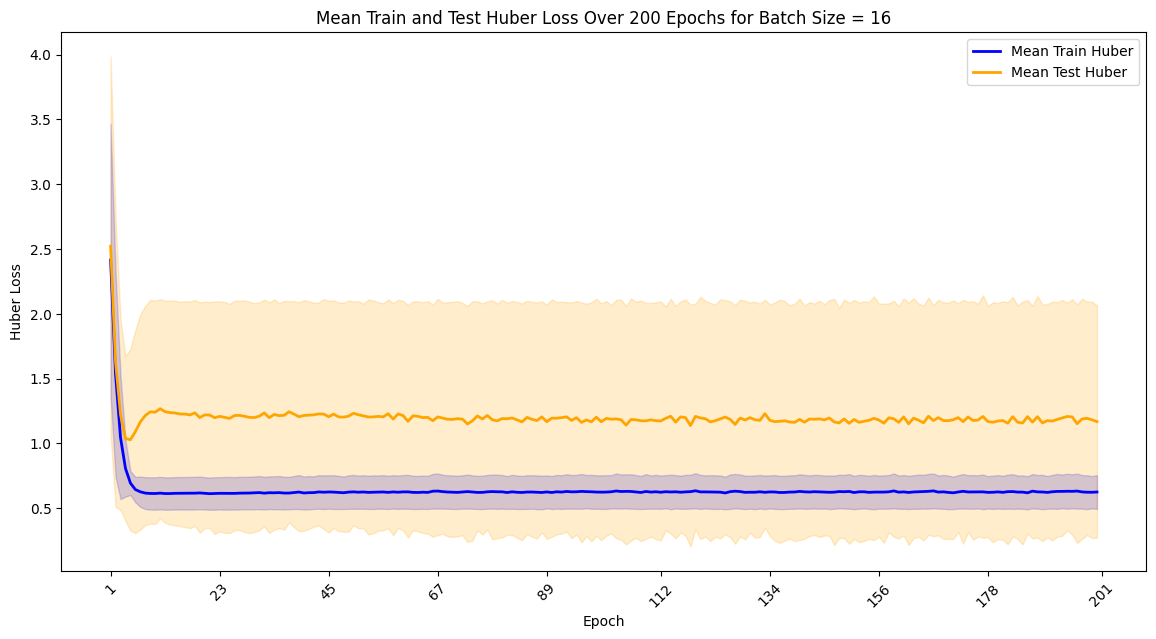

Testing with Batch Size: 32


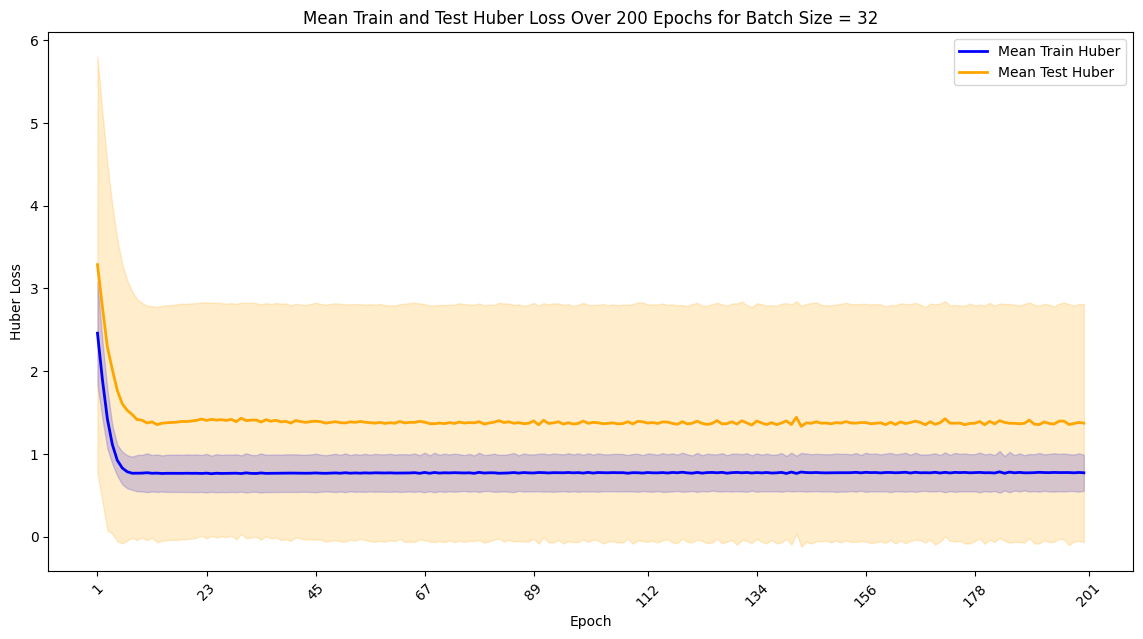

Testing with Batch Size: 64


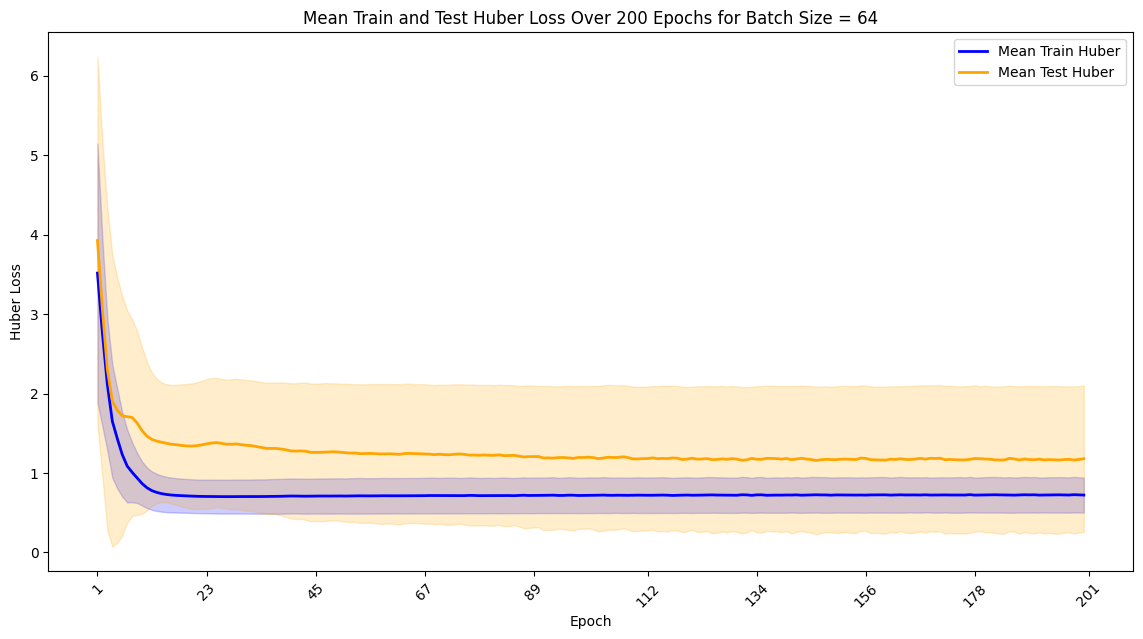

Testing with Batch Size: 128


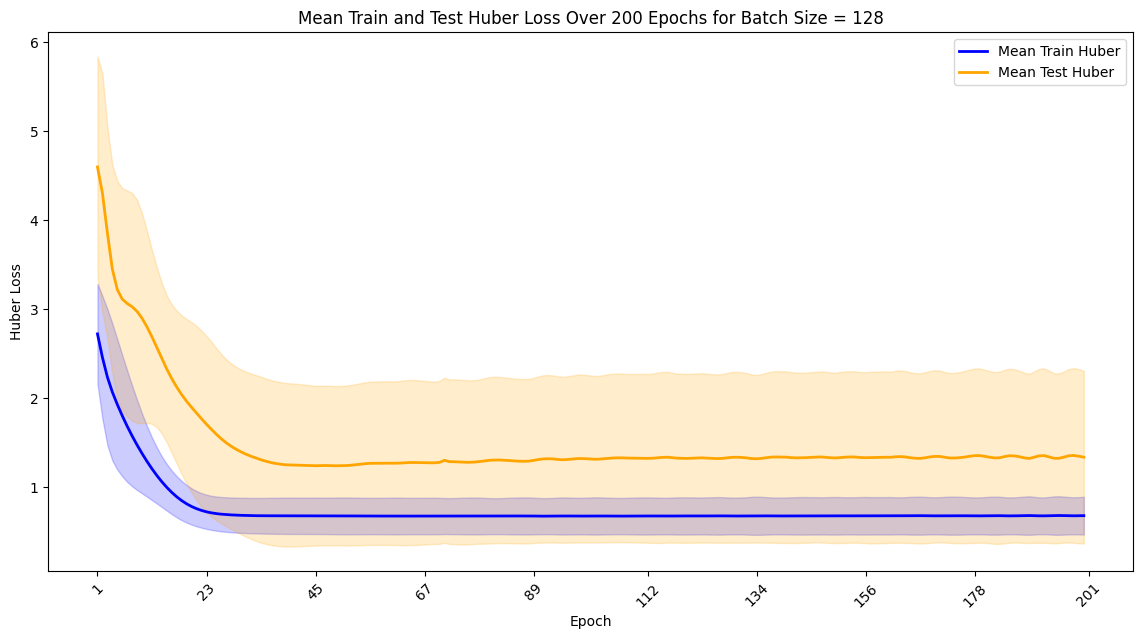

Testing with Batch Size: 256


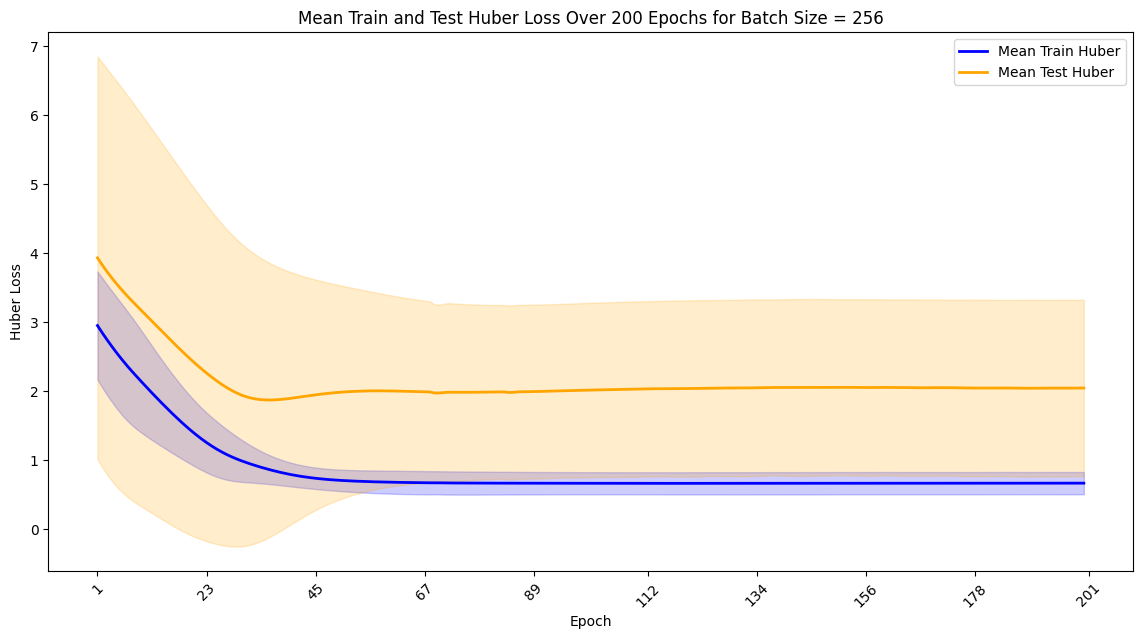

Summary of Test Huber Loss and Time for all Batch Size configurations:
    Batch Size  Test Huber Mean  Test Huber Std Dev  Test Huber Min  \
0           4         1.265298            0.811906        0.283959   
1           8         1.615765            1.056485        0.434209   
2          16         1.167724            0.896273        0.284821   
3          32         1.370608            1.438615        0.002350   
4          64         1.179884            0.920753        0.214852   
5         128         1.337338            0.971068        0.182127   
6         256         2.046280            1.277735        0.093482   

   Test Huber Max  Time Mean  Time Std Dev   Time Min   Time Max  
0        2.833586  50.246278      0.478314  49.601983  51.296391  
1        4.311317  32.066006      0.328654  31.647774  32.881750  
2        3.112693  22.863513      0.238846  22.511803  23.174080  
3        3.794633  20.857284      0.987504  19.951092  23.543860  
4        2.964329  17.825495    

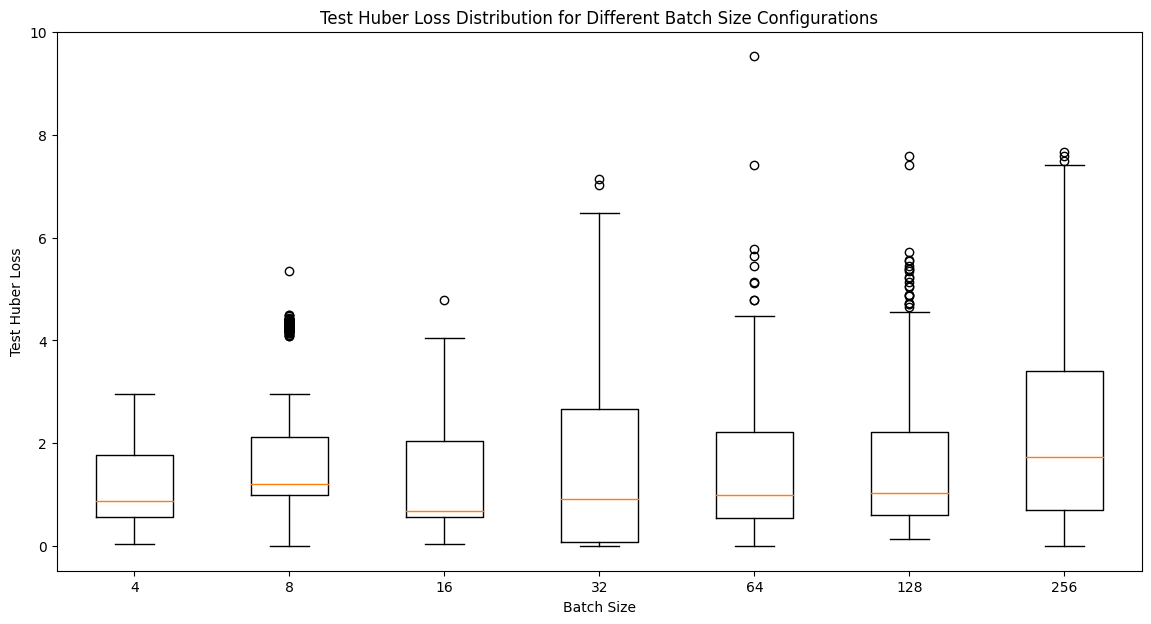

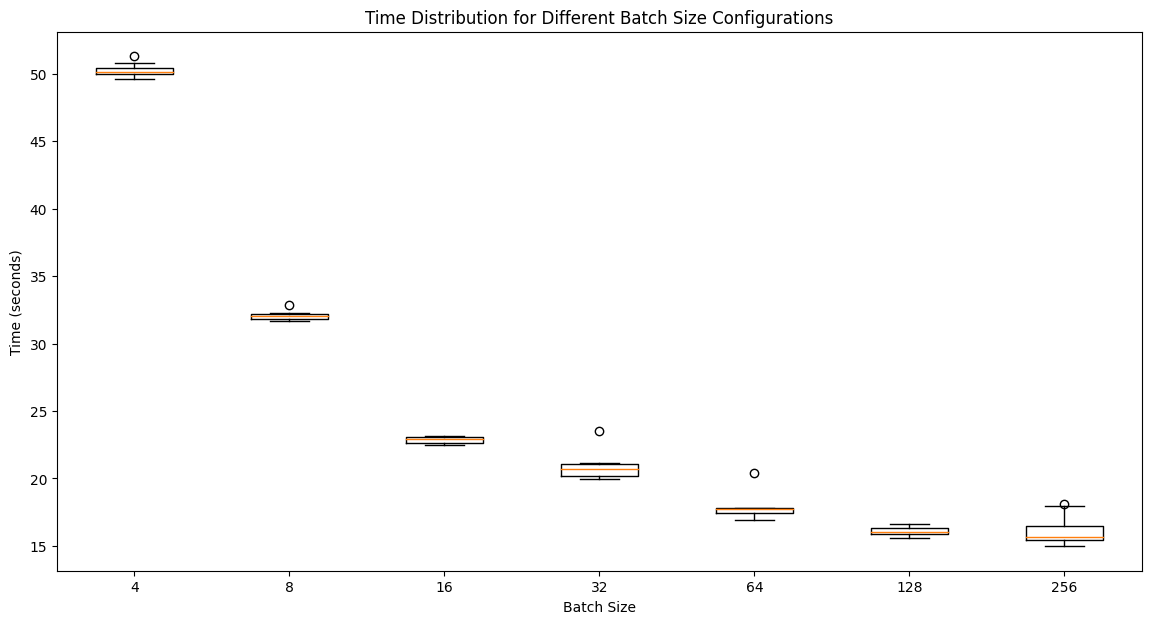

In [77]:

# Main logic
if CALCU_HYPER_PARAMETERS:
  # Example usage to find best batch size
    batch_sizes = [4, 8, 16, 32, 64,128,256]  # Example batch sizes to test
    evaluate_model_with_parameters(batch_sizes, 'Batch Size', lambda x: build_custom_lstm_model(my_input_shape), fixed_epochs=200)


## 5.5 Number of Neurons in Hidden Layer Analysis

Testing with Neuron Count: 1


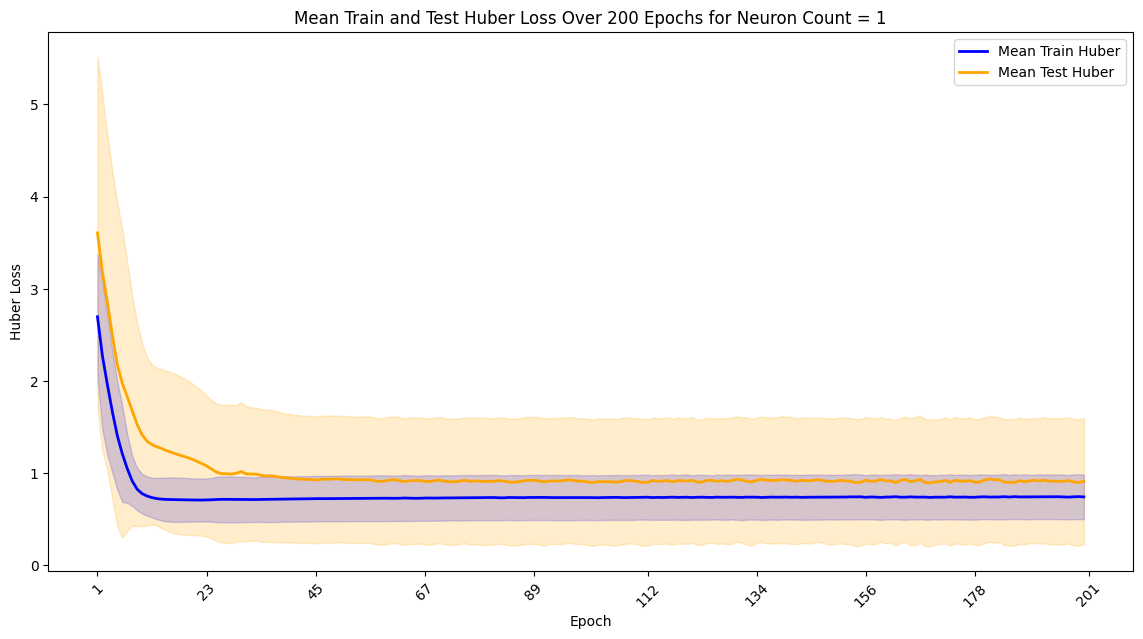

Testing with Neuron Count: 2


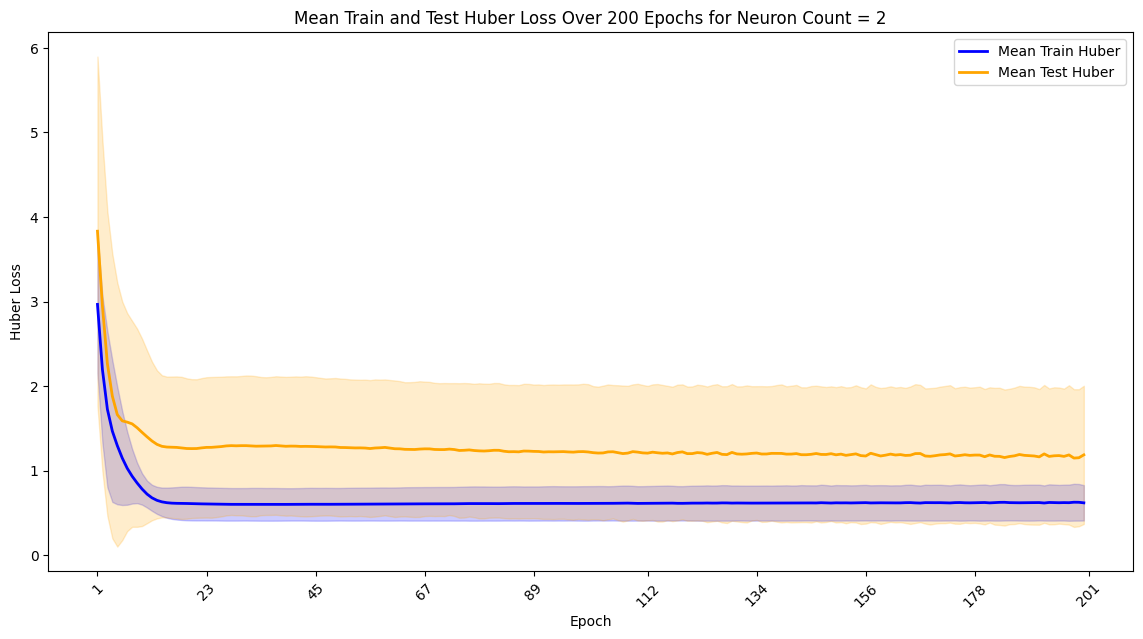

Testing with Neuron Count: 4


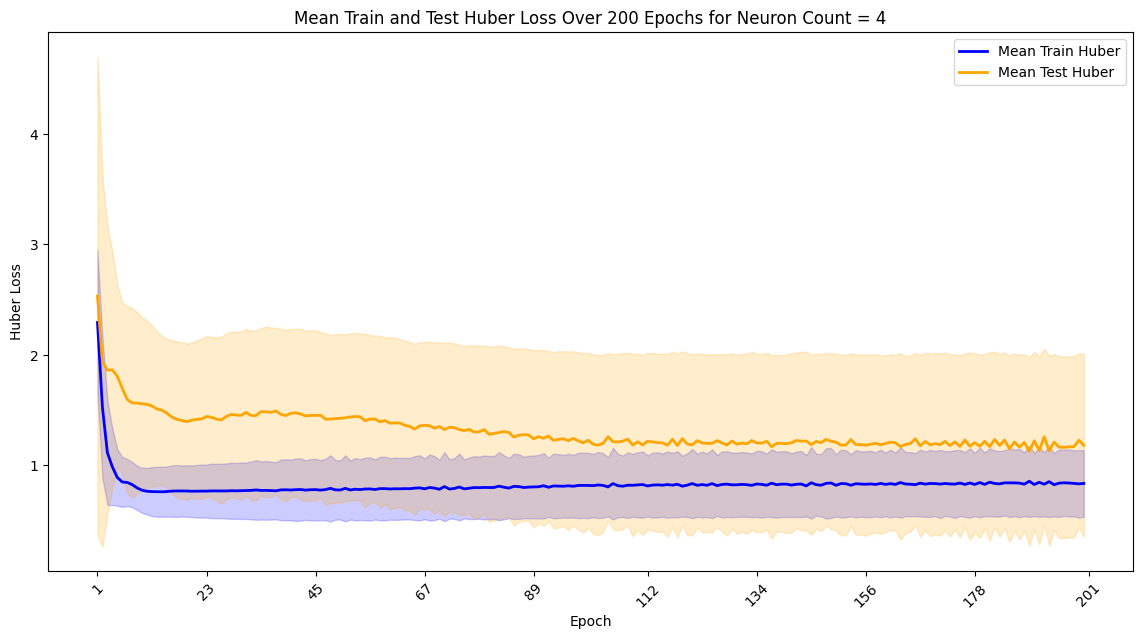

Testing with Neuron Count: 8


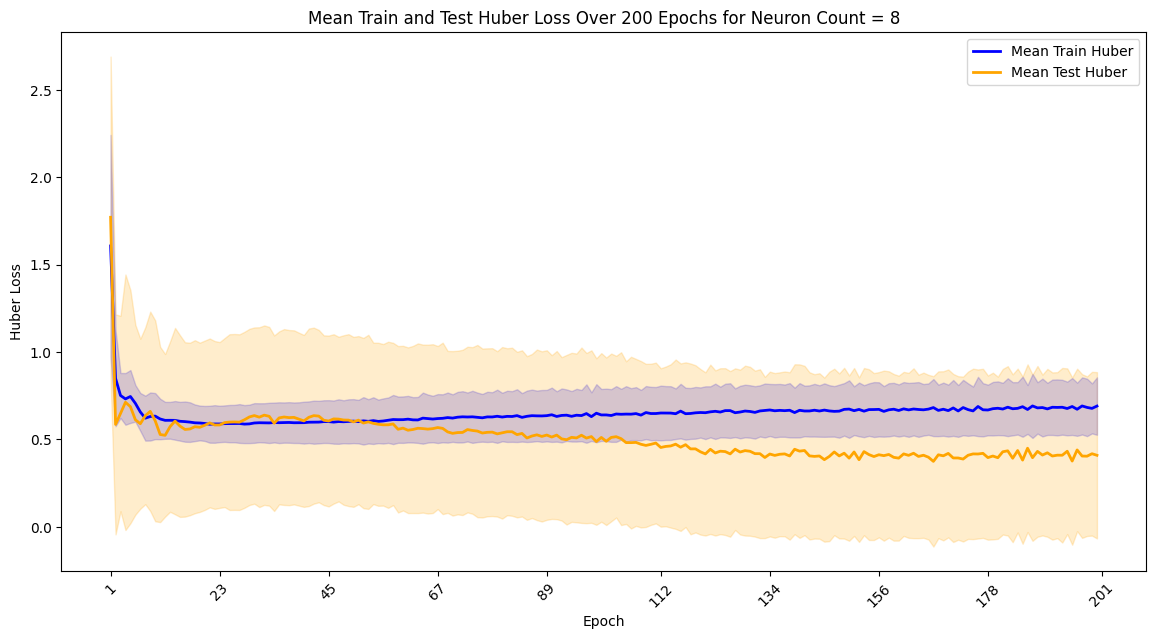

Testing with Neuron Count: 16


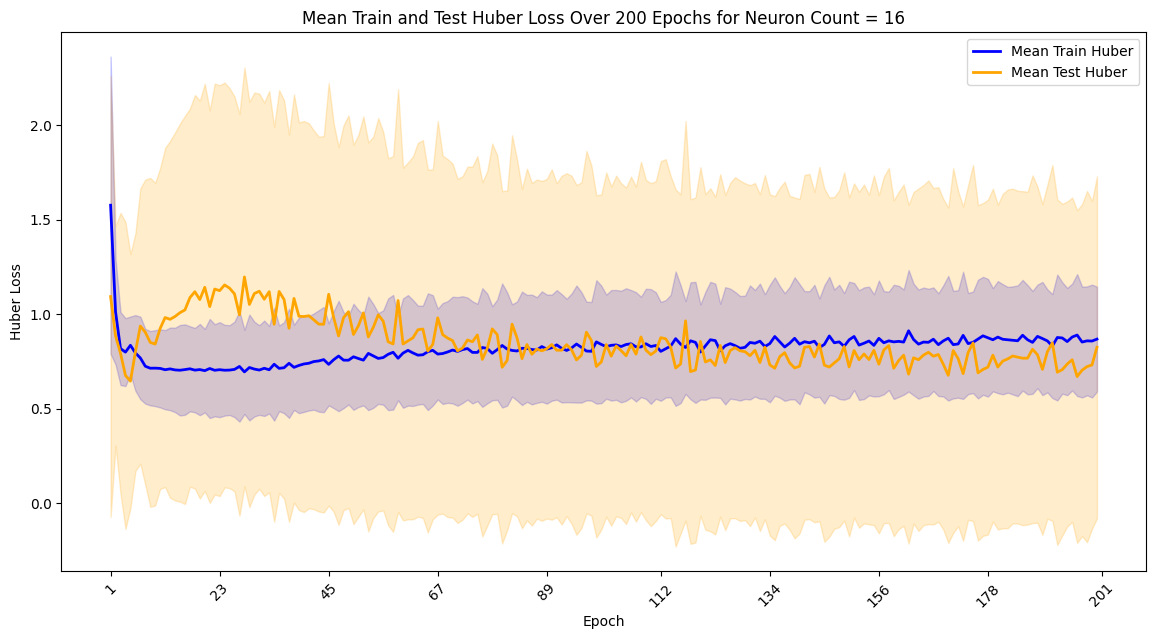

Testing with Neuron Count: 32


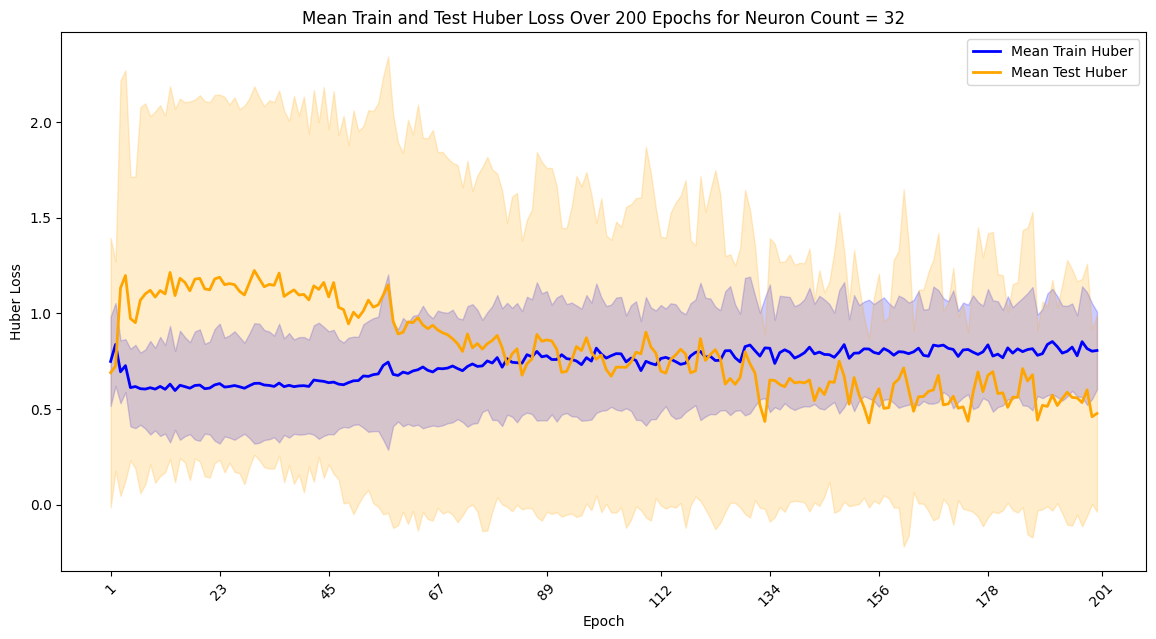

Testing with Neuron Count: 64


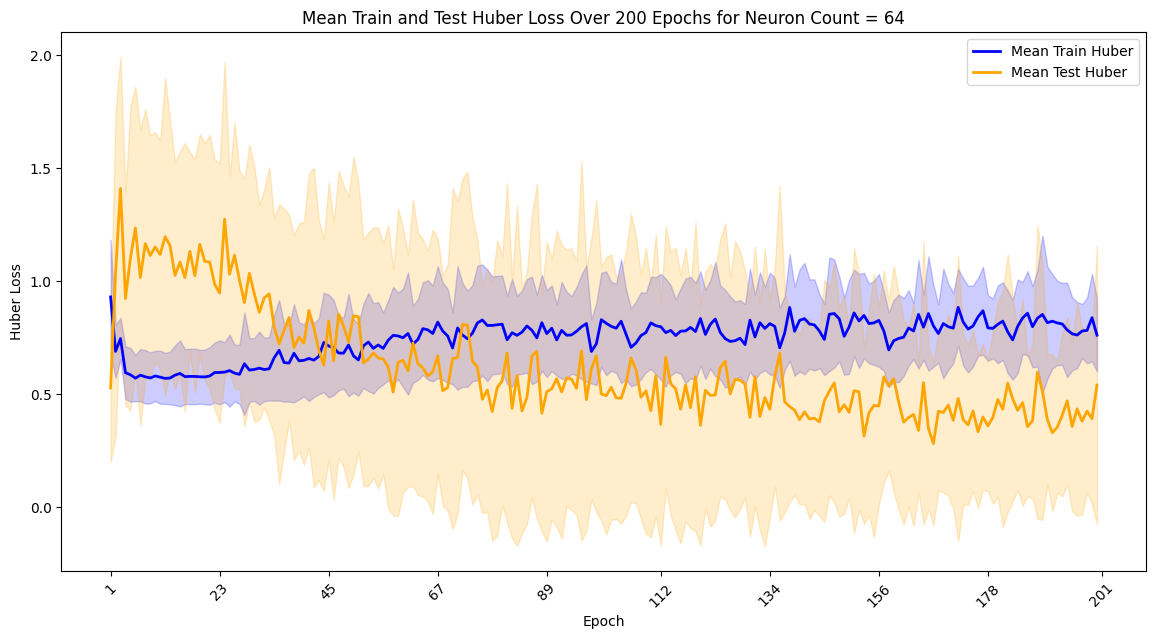

Testing with Neuron Count: 128


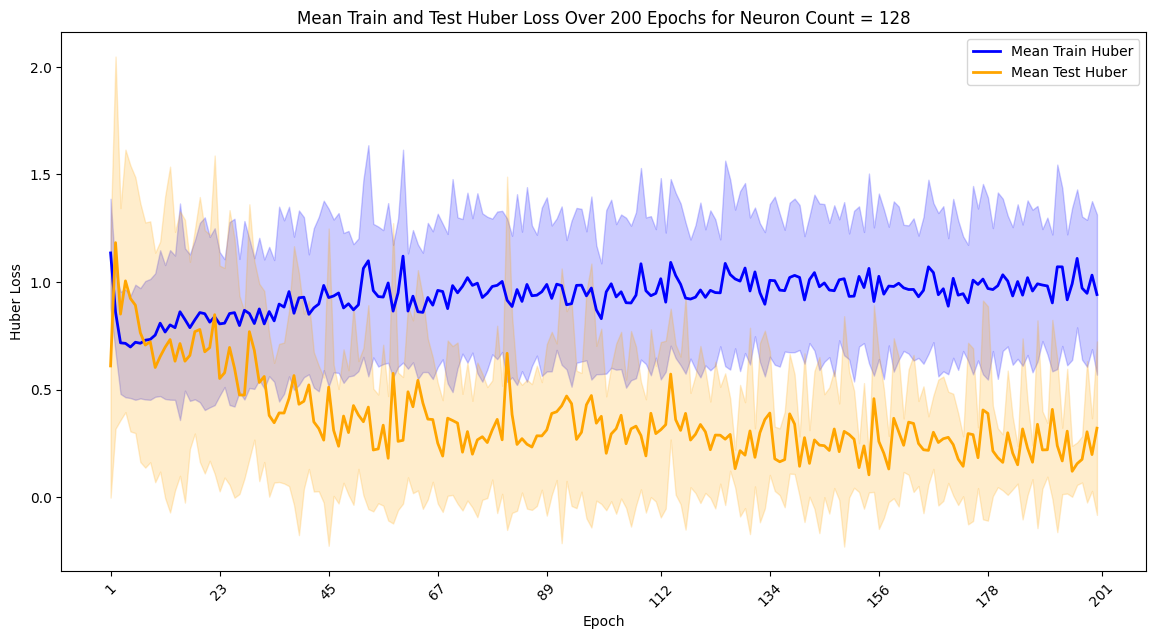

Testing with Neuron Count: 256


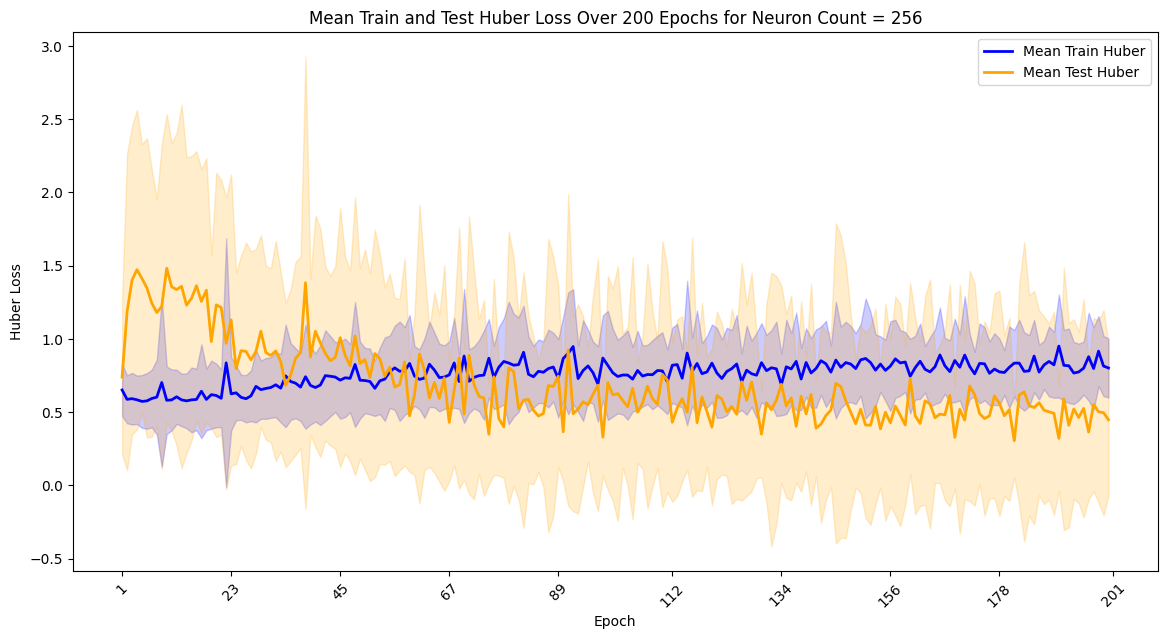

Summary of Test Huber Loss and Time for all Neuron Count configurations:
    Neuron Count  Test Huber Mean  Test Huber Std Dev  Test Huber Min  \
0             1         0.912088            0.686218        0.091705   
1             2         1.186427            0.817511        0.067574   
2             4         1.178749            0.829548        0.185987   
3             8         0.409530            0.475699        0.026940   
4            16         0.825020            0.903861        0.027515   
5            32         0.476491            0.512857        0.013359   
6            64         0.539497            0.617093        0.023242   
7           128         0.320828            0.403075        0.045227   
8           256         0.448271            0.519563        0.000160   

   Test Huber Max  Time Mean  Time Std Dev   Time Min   Time Max  
0        1.736611  17.591369      1.516429  16.682712  22.079775  
1        2.460284  17.505485      0.390342  16.962937  18.162191  
2   

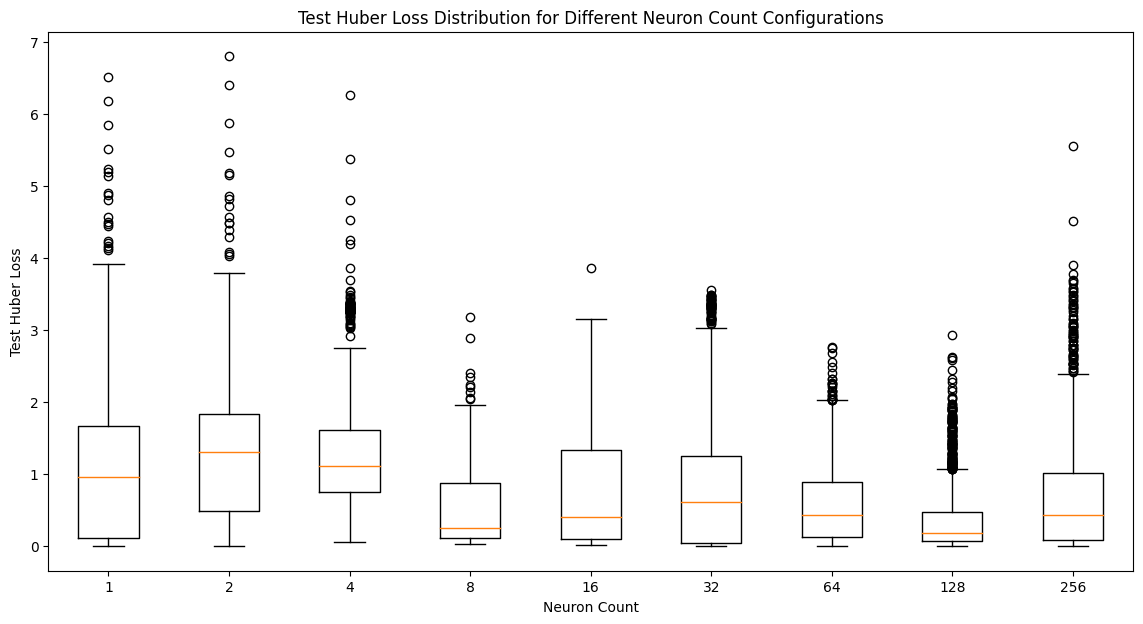

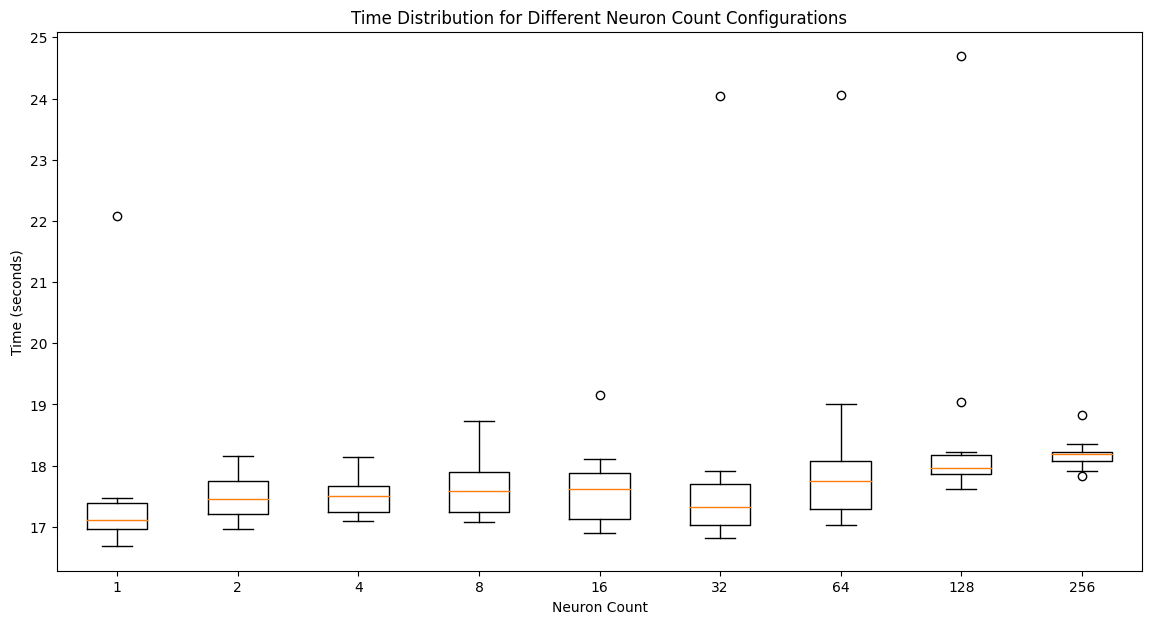

In [79]:

# Main logic
if CALCU_HYPER_PARAMETERS:
    # Example usage to find best neuron count
    neuron_counts = [1, 2, 4, 8,16,32,64,128,256]  # Example neuron counts to test
    evaluate_model_with_parameters(neuron_counts, 'Neuron Count', lambda x: build_custom_lstm_model(input_shape_custom=my_input_shape, neurons_num=x), fixed_epochs=200, fixed_batch_size=64)


# **Step 6. Model Comparison**

In [80]:

# Define the best hyperparameters

# LSTM Replace with the best hyperparameters found
best_epoch = 200
best_batch_size = 64
best_neuron_count = 8

# MLP Replace with the best hyperparameters found
neurons_layer1 = 12
neurons_layer2 = 13
learning_rate = 0.1

# Create and train the MLP model
def train_mlp(X_train, y_train, X_test, y_test, neurons_layer1, neurons_layer2, learning_rate):
    mlp = MLPRegressor(hidden_layer_sizes=(neurons_layer1, neurons_layer2), learning_rate_init=learning_rate, max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    mlp_predictions = mlp.predict(X_test)
    mlp_predictions_actual = inverse_transform_predictions(mlp_predictions, my_scaler, X_test)
    y_test_actual = inverse_transform_predictions(y_test, my_scaler, X_test)
    return mlp, mlp_predictions_actual, y_test_actual

# Create and train the LSTM model
def train_lstm(X_train, y_train, X_test, y_test, epochs, batch_size, neuron_count):
    model = build_custom_lstm_model(input_shape_custom=my_input_shape, neurons_num=neuron_count)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    lstm_predictions = model.predict(X_test)
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of lstm_predictions:", lstm_predictions.shape)
    print("Shape of lstm_predictions:", lstm_predictions)
    lstm_predictions_actual = inverse_transform_predictions(lstm_predictions, my_scaler, X_test)
    y_test_actual = inverse_transform_predictions(y_test, my_scaler, X_test)
    return model, lstm_predictions_actual, y_test_actual

# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mse, rmse, mae, r2

# Function to plot performance metrics
def plot_metrics(y_test_actual, mlp_predictions_actual, lstm_predictions_actual, time_test):
    plt.figure(figsize=(14, 7))
    plt.plot(time_test, y_test_actual, label='Actual PM2.5', color='blue')
    plt.plot(time_test, mlp_predictions_actual, label='Predicted PM2.5 (MLP)', color='orange', alpha=0.7)
    plt.plot(time_test, lstm_predictions_actual, label='Predicted PM2.5 (LSTM)', color='green', alpha=0.7)
    plt.title('PM2.5 Real and Prediction Values in MLP and LSTM')
    plt.xlabel('Time')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot comparison bar charts
def plot_comparison_bar_chart(mlp_metrics, lstm_metrics):
    labels = ['RMSE', 'MAE', 'R²']
    x = np.arange(len(labels))  # Number of metrics
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, mlp_metrics, width, label='MLP')
    rects2 = ax.bar(x + width/2, lstm_metrics, width, label='LSTM')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison of MLP and LSTM')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

# Inverse transform function
def inverse_transform_predictions(predictions, scaler, X_data):
    predictions_flat = predictions.reshape(-1, 1)
    zeros_shape = (predictions_flat.shape[0], X_data.shape[1]) if X_data.ndim == 2 else (predictions_flat.shape[0], X_data.shape[2])
    predictions_actual_flat = scaler.inverse_transform(np.concatenate([np.zeros(zeros_shape), predictions_flat], axis=1))[:, -1]
    predictions_actual = predictions_actual_flat.reshape(predictions.shape)
    return predictions_actual

train_size = int(len(X_scaler) * 0.7)
X_train, X_test = X_scaler[:train_size], X_scaler[train_size:]
y_train, y_test = y_scaler[:train_size], y_scaler[train_size:]

time_test = df.index[train_size + N_STEPS:]

mlp, mlp_predictions_actual, y_test_actual = train_mlp(X_train, y_train, X_test, y_test, neurons_layer1, neurons_layer2, learning_rate)
model, lstm_predictions_actual, y_test_lstm_actual = train_lstm(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, best_epoch, best_batch_size, best_neuron_count)


19/19 [==============================] - 0s 2ms/step
Shape of X_train: (1359, 2, 5)
Shape of y_train: (1359,)
Shape of X_test: (581, 2, 5)
Shape of lstm_predictions: (581, 1)
Shape of lstm_predictions: [[0.83482957]
 [0.8372241 ]
 [0.84003997]
 [0.8425484 ]
 [0.8447617 ]
 [0.8466928 ]
 [0.8479531 ]
 [0.8480946 ]
 [0.845724  ]
 [0.83992386]
 [0.83175766]
 [0.82178843]
 [0.80979764]
 [0.79560864]
 [0.77911055]
 [0.7564492 ]
 [0.7344735 ]
 [0.71110094]
 [0.68636024]
 [0.6602373 ]
 [0.63265735]
 [0.60347223]
 [0.5724511 ]
 [0.53926516]
 [0.5034579 ]
 [0.46435   ]
 [0.42217025]
 [0.39404118]
 [0.37360966]
 [0.35595244]
 [0.3384796 ]
 [0.32392985]
 [0.3166152 ]
 [0.31734747]
 [0.32137364]
 [0.32566553]
 [0.33021516]
 [0.33500698]
 [0.34001738]
 [0.3452145 ]
 [0.35055903]
 [0.35600585]
 [0.36150616]
 [0.36701024]
 [0.37247056]
 [0.3778441 ]
 [0.38363588]
 [0.3943293 ]
 [0.40471196]
 [0.4147535 ]
 [0.42443496]
 [0.44103584]
 [0.4571282 ]
 [0.472453  ]
 [0.48803827]
 [0.50409585]
 [0.516412  ]


In [81]:


lstm_predictions_actual = lstm_predictions_actual.reshape(-1)

# Ensure shapes are consistent
print('Shape of y_test_actual:', y_test_actual.shape)
print('Shape of mlp_predictions_actual:', mlp_predictions_actual.shape)
print('Shape of y_test_lstm_actual:', y_test_lstm_actual.shape)
print('Shape of lstm_predictions_actual:', lstm_predictions_actual.shape)
#print('Shape of lstm_predictions_actual_third_dim:', lstm_predictions_actual_third_dim.shape)
#print('Shape of y_test_lstm_actual_third_dim:', y_test_lstm_actual_third_dim.shape)



Shape of y_test_actual: (583,)
Shape of mlp_predictions_actual: (583,)
Shape of y_test_lstm_actual: (581,)
Shape of lstm_predictions_actual: (581,)


In [82]:
lstm_predictions_actual

array([8.43475198, 8.45536013, 8.47959398, 8.50118191, 8.52023063,
       8.53684991, 8.5476962 , 8.548914  , 8.52851206, 8.47859471,
       8.4083144 , 8.32251668, 8.21932098, 8.09720686, 7.95522018,
       7.76019112, 7.57106279, 7.36991243, 7.15698782, 6.93216737,
       6.69480731, 6.4436329 , 6.17665741, 5.89105075, 5.58288459,
       5.24631206, 4.88330273, 4.64121691, 4.46537815, 4.3134157 ,
       4.16304013, 4.03782124, 3.97486951, 3.98117164, 4.0158219 ,
       4.052759  , 4.09191419, 4.13315384, 4.17627456, 4.22100217,
       4.26699862, 4.31387532, 4.36121242, 4.40858184, 4.45557474,
       4.50182074, 4.55166628, 4.64369662, 4.73305232, 4.81947228,
       4.90279337, 5.04566467, 5.18415955, 5.31604862, 5.45017938,
       5.58837493, 5.69437094, 5.75688382, 5.80434865, 5.85082601,
       5.89635847, 5.94098554, 5.98474312, 6.02766352, 6.06977856,
       6.11111491, 6.15169873, 6.19155413, 6.23070316, 6.26916584,
       6.30696267, 6.34410958, 6.38062449, 6.41652385, 6.45182

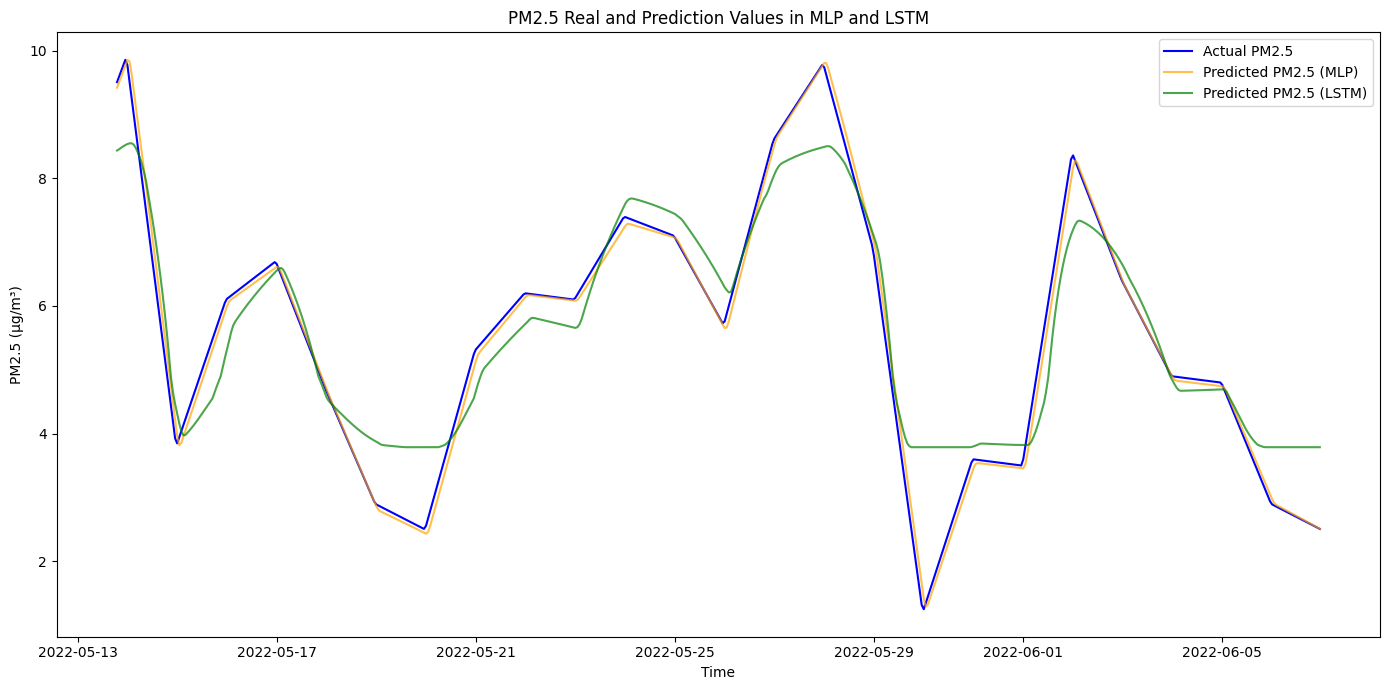

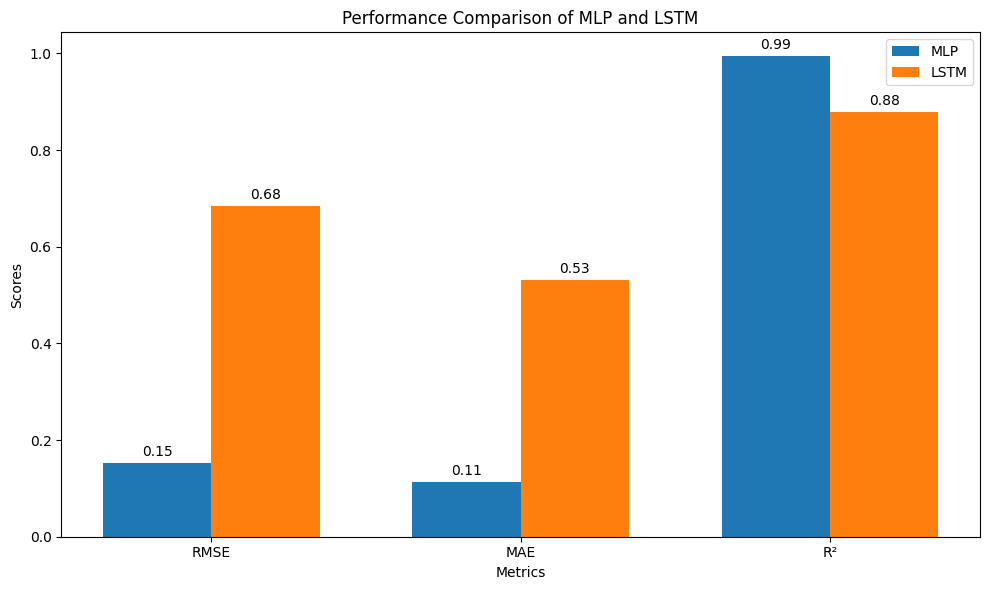

MLP Performance:
RMSE: 0.1523230754119499
MAE: 0.11225667685215686
R²: 0.9940461421020389

LSTM Performance:
RMSE: 0.6834049238839086
MAE: 0.531406333841138
R²: 0.8789903142856332

MLP Model Summary:
Hidden Layers: (12, 13)
Number of iterations: 23
Learning rate: 0.1

LSTM Model Summary:
Model: "sequential_271"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_271 (LSTM)             (None, 8)                 448       
                                                                 
 dropout_542 (Dropout)       (None, 8)                 0         
                                                                 
 dense_542 (Dense)           (None, 8)                 72        
                                                                 
 dropout_543 (Dropout)       (None, 8)                 0         
                                                                 
 dense_543 (Dense)         

In [83]:

# Calculate metrics
mlp_mse, mlp_rmse, mlp_mae, mlp_r2 = calculate_metrics(y_test_actual, mlp_predictions_actual)
lstm_mse, lstm_rmse, lstm_mae, lstm_r2 = calculate_metrics(y_test_lstm_actual, lstm_predictions_actual)

# Plot actual and predicted PM2.5 values
plot_metrics(y_test_actual[N_STEPS:], mlp_predictions_actual[N_STEPS:], lstm_predictions_actual, time_test)

# Plot performance metrics comparison
plot_comparison_bar_chart([mlp_rmse, mlp_mae, mlp_r2], [lstm_rmse, lstm_mae, lstm_r2])

# Print performance metrics for MLP
print("MLP Performance:")
print(f"RMSE: {mlp_rmse}")
print(f"MAE: {mlp_mae}")
print(f"R²: {mlp_r2}")

# Print performance metrics for LSTM
print("\nLSTM Performance:")
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R²: {lstm_r2}")

# Print model summaries
print("\nMLP Model Summary:")
print(f"Hidden Layers: {mlp.hidden_layer_sizes}")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Learning rate: {mlp.learning_rate_init}")

print("\nLSTM Model Summary:")
model.summary()